# **ShowsSpeed – F1 Data Analytics & ML Models**

#### Author: Anthony Tian

#### Let's see where this takes us... oh boy, a lotta data here, we're in for a doozy

In [949]:
import os, re, math, glob, time, random, logging, traceback, zipfile
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import textwrap
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, to_rgb
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from PIL import Image

# stats & ML
from scipy import stats
from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve



# domain-specific
import fastf1
from fastf1.core import Laps

#### Data Processing & Preparation:

In [5]:
def unzip_main(zip_path, extract_dir):
  extract_dir=Path(extract_dir);extract_dir.mkdir(parents=True,exist_ok=True)
  with zipfile.ZipFile(zip_path,'r') as z: z.extractall(extract_dir)
  return extract_dir

In [6]:
def load_raw_csvs(extract_dir):
  extract_dir=Path(extract_dir)
  raw={}
  for p in extract_dir.glob("*.csv"):
    key=re.sub(r"^f1db-","",p.stem)
    df=pd.read_csv(p,low_memory=False)
    raw[key]=df
  return raw

In [7]:
zip_path="/Users/showhq/Downloads/f1db-csv.zip" 
extract_dir="ShowsSpeed/data_raw/f1db"

In [8]:
out_dir=unzip_main(zip_path,extract_dir)
raw_dfs=load_raw_csvs(out_dir)

In [9]:
# df_guide: general information about each dataset/df here
df_guide = pd.DataFrame([{"name": name,
                          "rows": df.shape[0],
                          "cols": df.shape[1],
                          "sample_cols": list(df.columns)[:5]}
                         for name, df in raw_dfs.items()])
df_guide

,name,rows,cols,sample_cols
0,seasons-tyre-manufacturers,159,12,"[year, tyreManufacturerId, bestStartingGridPos..."
1,grands-prix,53,7,"[id, name, fullName, shortName, abbreviation]"
2,races-pit-stops,21787,15,"[raceId, year, round, positionDisplayOrder, po..."
3,races-starting-grid-positions,25328,17,"[raceId, year, round, positionDisplayOrder, po..."
4,seasons-constructors,1068,16,"[year, constructorId, positionNumber, position..."
5,chassis,1138,4,"[id, constructorId, name, fullName]"
6,races-warming-up-results,7683,18,"[raceId, year, round, positionDisplayOrder, po..."
7,seasons-entrants-tyre-manufacturers,1944,5,"[year, entrantId, constructorId, engineManufac..."
8,races-sprint-race-results,420,34,"[raceId, year, round, positionDisplayOrder, po..."
9,races-qualifying-2-results,7541,24,"[raceId, year, round, positionDisplayOrder, po..."


# Pivoting to FastF1 API:
**In order to answer some of the questions I want, weather and lap-by-lap related thus far, more data is needed. Gonna try this FastF1 thing, looks like exactly what I'm looking for:**
https://docs.fastf1.dev/

In [251]:
import fastf1 as f1
print(f1.__version__)

3.6.0


In [253]:
!pwd
!ls -la

/Users/showhq/ShowsSpeed
total 1776
drwxr-xr-x  26 showhq  staff     832 Aug 29 16:47 .
drwxr-xr-x+ 68 showhq  staff    2176 Aug 29 15:01 ..
drwxr-xr-x   6 showhq  staff     192 Aug 24 11:48 .ipynb_checkpoints
drwxr-xr-x   6 showhq  staff     192 Aug 22 23:21 data
-rw-r--r--   1 showhq  staff     906 Aug 24 11:49 FastF1_API_Data_Gathering.ipynb
drwxr-xr-x   4 showhq  staff     128 Aug 23 00:18 fastf1_cache
drwxr-xr-x   4 showhq  staff     128 Aug 24 08:06 fastf1_cache_2023
drwxr-xr-x   4 showhq  staff     128 Aug 24 18:28 fastf1_cache_2024
drwxr-xr-x   4 showhq  staff     128 Aug 29 15:39 fastf1_cache_2025
drwxr-xr-x   4 showhq  staff     128 Aug 23 00:43 fastf1_cache_clean
drwxr-xr-x   4 showhq  staff     128 Aug 23 19:01 fastf1_cache_run2
-rw-r--r--   1 showhq  staff   18440 Aug 23 00:43 fetch_2022.log
-rw-r--r--   1 showhq  staff    2420 Aug 29 15:37 fetch_2023.log
-rw-r--r--   1 showhq  staff    2420 Aug 29 15:37 fetch_2024.log
-rw-r--r--   1 showhq  staff   65750 Aug 29 15:40 fetc

In [616]:
YEAR=2022
ROUNDS=list(range(1,23))
SESSIONS=["Q","R"]  # just want Qualifying & Race Day data
CACHE=Path("fastf1_cache_run2")
OUT=Path(f"out_ff1/{YEAR}")
OUT.mkdir(parents=True, exist_ok=True)

ENABLE_LAPS=True
ENABLE_TELEM=False
MAX_RETRIES=3
SLEEP_BETWEEN_RETRIES=20

SESSIONS_PER_HOUR_CAP=6
INTER_SESSION_SLEEP_MIN=15
INTER_SESSION_SLEEP_MAX=25

In [257]:
def setup():
    CACHE.mkdir(exist_ok=True)
    fastf1.Cache.enable_cache(str(CACHE))
    logging.basicConfig(level=logging.INFO,format="%(asctime)s %(levelname)s %(message)s")

In [259]:
def save_df(df, base):
    if df is None or len(df)==0: return
    base.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(base.with_suffix(".csv"), index=False)
    try: df.to_parquet(base.with_suffix(".parquet"), index=False)
    except Exception: pass

In [315]:
def minimal_results(ses):
    try:
        r=ses.results.copy()
        keep=[c for c in r.columns if c.lower() in {
            "drivernumber","broadcastname","abbreviation","teamname","teamcolor",
            "position","status","points","gridposition","q1","q2","q3","fastestlap",
            "time","timedelta"}]
        return r[keep] if keep else r
    except Exception:
        return pd.DataFrame()

In [317]:
def extract_laps(ses):
    try:
        laps:Laps=ses.laps
        if laps is None or len(laps)==0: return pd.DataFrame()
        cols=[c for c in laps.columns if c in [
            "Driver","DriverNumber","Team","LapTime","LapNumber","Stint","Compound",
            "TyreLife","IsAccurate","IsPitOutLap","IsPitInLap",
            "Sector1Time","Sector2Time","Sector3Time"]]
        base=laps[cols].copy() if cols else laps.copy()
        base["RoundNumber"]=ses.event["RoundNumber"]
        base["SessionName"]=ses.name
        base["EventName"]=ses.event["EventName"]
        return base
    except Exception:
        return pd.DataFrame()

In [265]:
def load_with_retry(year, rnd, which):
    for attempt in range(1,MAX_RETRIES+1):
        try:
            ses=fastf1.get_session(year, rnd, which)
            ses.load(telemetry=ENABLE_TELEM, weather=True)
            return ses
        except Exception as e:
            logging.warning(f"[{year} R{rnd} {which}] attempt {attempt}/{MAX_RETRIES} failed: {e}")
            logging.debug(traceback.format_exc())
            if attempt<MAX_RETRIES:
                time.sleep(SLEEP_BETWEEN_RETRIES*(2**(attempt-1)))
    return None

window_start=None
sessions_this_window=0

In [267]:
def wait_for_window():
    global window_start, sessions_this_window
    now=datetime.utcnow()
    if window_start is None:
        window_start=now; sessions_this_window=0; return
    if now-window_start>=timedelta(hours=1):
        window_start=now; sessions_this_window=0; return
    if sessions_this_window>=SESSIONS_PER_HOUR_CAP:
        wake=window_start+timedelta(hours=1,seconds=3)
        sleep_s=max(3,int((wake-now).total_seconds()))
        logging.info(f"hourly cap reached ({SESSIONS_PER_HOUR_CAP}); sleeping {sleep_s}s until window reset")
        time.sleep(sleep_s)
        window_start=datetime.utcnow(); sessions_this_window=0

In [269]:
def paced_session_run(year, rnd, which):
    global sessions_this_window
    wait_for_window()
    tag=f"y{year}_r{rnd:02d}_{which.lower()}"
    base=OUT/tag
    if (base.with_name(base.name+"_results.csv")).exists():
        logging.info(f"skip existing {tag}"); return
    logging.info(f"loading {tag}")
    ses=load_with_retry(year, rnd, which)
    if ses is None:
        logging.error(f"give up {tag}"); return
    save_df(minimal_results(ses), base.with_name(base.name+"_results"))
    if ENABLE_LAPS:
        save_df(extract_laps(ses), base.with_name(base.name+"_laps"))
    sessions_this_window+=1
    cool=random.randint(INTER_SESSION_SLEEP_MIN, INTER_SESSION_SLEEP_MAX)
    logging.info(f"done {tag}; cool {cool}s (window {sessions_this_window}/{SESSIONS_PER_HOUR_CAP})")
    time.sleep(cool)

In [271]:
def main():
    setup()
    for rnd in ROUNDS:
        for which in SESSIONS:
            paced_session_run(YEAR, rnd, which)
if __name__=="__main__":
    main()

2025-08-29 16:48:24,257 INFO skip existing y2022_r01_q
2025-08-29 16:48:24,261 INFO skip existing y2022_r01_r
2025-08-29 16:48:24,262 INFO skip existing y2022_r02_q
2025-08-29 16:48:24,263 INFO skip existing y2022_r02_r
2025-08-29 16:48:24,264 INFO skip existing y2022_r03_q
2025-08-29 16:48:24,265 INFO skip existing y2022_r03_r
2025-08-29 16:48:24,266 INFO skip existing y2022_r04_q
2025-08-29 16:48:24,267 INFO skip existing y2022_r04_r
2025-08-29 16:48:24,268 INFO skip existing y2022_r05_q
2025-08-29 16:48:24,269 INFO skip existing y2022_r05_r
2025-08-29 16:48:24,270 INFO skip existing y2022_r06_q
2025-08-29 16:48:24,271 INFO skip existing y2022_r06_r
2025-08-29 16:48:24,271 INFO skip existing y2022_r07_q
2025-08-29 16:48:24,272 INFO skip existing y2022_r07_r
2025-08-29 16:48:24,273 INFO skip existing y2022_r08_q
2025-08-29 16:48:24,274 INFO skip existing y2022_r08_r
2025-08-29 16:48:24,274 INFO skip existing y2022_r09_q
2025-08-29 16:48:24,275 INFO skip existing y2022_r09_r
2025-08-29

In [1246]:
q_done = sorted(glob.glob("out_ff1/2022/y2022_r??_q_results.csv"))
r_done = sorted(glob.glob("out_ff1/2022/y2022_r??_r_results.csv"))
print("Q:", len(q_done), "/ 22")
print("R:", len(r_done), "/ 22")

missing = [(s, r) for s in ["q","r"] for r in range(1,23)
           if not os.path.exists(f"out_ff1/2022/y2022_r{r:02d}_{s}_results.csv")]
print("Remaining:", missing[:10], ", Total:", len(missing))

Q: 22 / 22
R: 22 / 22
Remaining: [] , Total: 0


#### Scraping 2022 Data (Qualifying and Race Day):

In [321]:
YEAR = 2022
OUT_DIR = Path(f"out_ff1/{YEAR}")
SAVE_DIR = Path("model_data"); SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [323]:
def load_qr_laps(year=YEAR):
    files = sorted(glob.glob(str(OUT_DIR / f"y{year}_r??_q_laps.csv"))) \
          + sorted(glob.glob(str(OUT_DIR / f"y{year}_r??_r_laps.csv")))
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # session type from filename
        s_type = "Q" if "_q_laps" in f else "R"
        # round from filename
        m = re.search(r"_r(\d{2})_", f)
        rnd = int(m.group(1)) if m else None
        df["year"] = year
        df["round"] = rnd
        df["session_type"] = s_type
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [325]:
qr_2022 = load_qr_laps()

In [369]:
def td_to_s(series):
    td = pd.to_timedelta(series, errors="coerce")
    return td.dt.total_seconds()

In [371]:
for col in ["LapTime","Sector1Time","Sector2Time","Sector3Time",
            "LapNumber","Driver","DriverNumber","Team",
            "Stint","Compound","TyreLife","IsPitOutLap","IsPitInLap","IsAccurate",
            "EventName","SessionName","RoundNumber"]:
    if col not in qr_2022.columns:
        qr_2022[col] = pd.NA

In [335]:
qr_2022_df = pd.DataFrame({
    "year": qr_2022["year"],
    "round": qr_2022["round"].fillna(qr_2022["RoundNumber"]),
    "session_type": qr_2022["session_type"],
    "event_name": qr_2022.get("EventName"),
    "session_name": qr_2022.get("SessionName"),
    "driver": qr_2022.get("Driver"),
    "driver_number": qr_2022.get("DriverNumber"),
    "team": qr_2022.get("Team"),
    "lap": qr_2022.get("LapNumber"),
    "lap_time_s": td_to_s(qr_2022.get("LapTime")),
    "s1_s": td_to_s(qr_2022.get("Sector1Time")),
    "s2_s": td_to_s(qr_2022.get("Sector2Time")),
    "s3_s": td_to_s(qr_2022.get("Sector3Time")),
    "stint": qr_2022.get("Stint"),
    "compound": qr_2022.get("Compound"),
    "tyre_life": qr_2022.get("TyreLife"),
    "is_pit_out": qr_2022.get("IsPitOutLap").astype("boolean"),
    "is_pit_in": qr_2022.get("IsPitInLap").astype("boolean"),
    "is_accurate": qr_2022.get("IsAccurate").astype("boolean"),})

In [337]:
qr_2022_df = qr_2022_df.dropna(subset=["lap_time_s"])
if "is_accurate" in qr_2022_df.columns:
    qr_2022_df = qr_2022_df[(qr_2022_df["is_accurate"].isna()) | (qr_2022_df["is_accurate"])]

out_parquet = SAVE_DIR / "qr_laps_2022.parquet"
out_csv = SAVE_DIR / "qr_laps_2022.csv"
qr_2022_df.to_parquet(out_parquet, index=False)
qr_2022_df.to_csv(out_csv, index=False)

In [339]:
print(qr_2022_df.shape)
qr_2022_df.head()

(22863, 19)


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
1,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2.0,91.471,29.367,39.067,23.037,1.0,SOFT,2.0,<NA>,<NA>,True
4,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,5.0,91.356,29.413,39.065,22.878,2.0,SOFT,5.0,<NA>,<NA>,True
7,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,8.0,90.932,29.355,38.850,22.727,3.0,SOFT,2.0,<NA>,<NA>,True
10,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,11.0,90.731,29.199,38.825,22.707,4.0,SOFT,2.0,<NA>,<NA>,True
13,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,14.0,90.558,29.115,38.702,22.741,5.0,SOFT,2.0,<NA>,<NA>,True


In [341]:
!mkdir -p out_ff1/2023 out_ff1/2024 out_ff1/2025 fastf1_cache_2023 fastf1_cache_2024 fastf1_cache_2025

In [343]:
!PYTHONUNBUFFERED=1 python -u ff1_fetch_2023_paced_full.py 2>&1 | tee fetch_2023.log

2025-08-29 16:57:15,148 INFO skip existing y2023_r01_q
2025-08-29 16:57:15,148 INFO skip existing y2023_r01_r
2025-08-29 16:57:15,148 INFO skip existing y2023_r02_q
2025-08-29 16:57:15,148 INFO skip existing y2023_r02_r
2025-08-29 16:57:15,148 INFO skip existing y2023_r03_q
2025-08-29 16:57:15,149 INFO skip existing y2023_r03_r
2025-08-29 16:57:15,149 INFO skip existing y2023_r04_q
2025-08-29 16:57:15,149 INFO skip existing y2023_r04_r
2025-08-29 16:57:15,149 INFO skip existing y2023_r05_q
2025-08-29 16:57:15,149 INFO skip existing y2023_r05_r
2025-08-29 16:57:15,149 INFO skip existing y2023_r06_q
2025-08-29 16:57:15,149 INFO skip existing y2023_r06_r
2025-08-29 16:57:15,149 INFO skip existing y2023_r07_q
2025-08-29 16:57:15,149 INFO skip existing y2023_r07_r
2025-08-29 16:57:15,149 INFO skip existing y2023_r08_q
2025-08-29 16:57:15,149 INFO skip existing y2023_r08_r
2025-08-29 16:57:15,149 INFO skip existing y2023_r09_q
2025-08-29 16:57:15,149 INFO skip existing y2023_r09_r
2025-08-29

#### Scraping 2023 Data (Qualifying and Race Day):

In [345]:
YEAR = 2023
OUT_DIR = Path(f"out_ff1/{YEAR}")
SAVE_DIR = Path("model_data"); SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [346]:
def load_qr_laps_2023(year=YEAR):
    files = sorted(glob.glob(str(OUT_DIR / f"y{year}_r??_q_laps.csv"))) \
          + sorted(glob.glob(str(OUT_DIR / f"y{year}_r??_r_laps.csv")))
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        s_type = "Q" if "_q_laps" in f else "R"
        m = re.search(r"_r(\d{2})_", f)
        rnd = int(m.group(1)) if m else None
        df["year"] = year
        df["round"] = rnd
        df["session_type"] = s_type
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [350]:
qr_2023 = load_qr_laps_2023()

In [352]:
for col in ["LapTime","Sector1Time","Sector2Time","Sector3Time",
            "LapNumber","Driver","DriverNumber","Team",
            "Stint","Compound","TyreLife","IsPitOutLap","IsPitInLap","IsAccurate",
            "EventName","SessionName","RoundNumber"]:
    if col not in qr_2023.columns:
        qr_2023[col] = pd.NA

In [1248]:
qr_2023_df = pd.DataFrame({"year": qr_2023["year"],
                           "round": qr_2023["round"].fillna(qr_2023["RoundNumber"]),
                           "session_type": qr_2023["session_type"],
                           "event_name": qr_2023.get("EventName"),
                           "session_name": qr_2023.get("SessionName"),
                           "driver": qr_2023.get("Driver"),
                           "driver_number": qr_2023.get("DriverNumber"),
                           "team": qr_2023.get("Team"),
                           "lap": qr_2023.get("LapNumber"),
                           "lap_time_s": td_to_s(qr_2023.get("LapTime")),
                           "s1_s": td_to_s(qr_2023.get("Sector1Time")),
                           "s2_s": td_to_s(qr_2023.get("Sector2Time")),
                           "s3_s": td_to_s(qr_2023.get("Sector3Time")),
                           "stint": qr_2023.get("Stint"),
                           "compound": qr_2023.get("Compound"),
                           "tyre_life": qr_2023.get("TyreLife"),
                           "is_pit_out": qr_2023.get("IsPitOutLap").astype("boolean"),
                           "is_pit_in": qr_2023.get("IsPitInLap").astype("boolean"),
                           "is_accurate": qr_2023.get("IsAccurate").astype("boolean"),})

In [356]:
qr_2023_df = qr_2023_df.dropna(subset=["lap_time_s"])
if "is_accurate" in qr_2023_df.columns:
    qr_2023_df = qr_2023_df[(qr_2023_df["is_accurate"].isna()) | (qr_2023_df["is_accurate"])]

out_parquet = SAVE_DIR / "qr_laps_2023.parquet"
out_csv = SAVE_DIR / "qr_laps_2023.csv"
qr_2023_df.to_parquet(out_parquet, index=False)
qr_2023_df.to_csv(out_csv, index=False)

In [358]:
print(qr_2023_df.shape, "rows, cols")
qr_2023_df.head()

(24631, 19) rows, cols


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
2,2023,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,3.0,91.295,29.152,39.195,22.948,2.0,SOFT,3.0,<NA>,<NA>,True
7,2023,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,8.0,90.503,28.925,38.915,22.663,4.0,SOFT,2.0,<NA>,<NA>,True
10,2023,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,11.0,89.897,28.722,38.645,22.530,5.0,SOFT,2.0,<NA>,<NA>,True
13,2023,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,14.0,89.708,28.736,38.514,22.458,6.0,SOFT,2.0,<NA>,<NA>,True
17,2023,1,Q,Bahrain Grand Prix,Qualifying,PER,11,Red Bull Racing,3.0,91.479,29.218,39.397,22.864,2.0,SOFT,3.0,<NA>,<NA>,True


#### Scraping 2024 Data (Qualifying and Race Day):

In [361]:
!PYTHONUNBUFFERED=1 python -u ff1_fetch_2024_paced_full.py 2>&1 | tee fetch_2024.log

2025-08-29 16:57:21,822 INFO skip existing y2024_r01_q
2025-08-29 16:57:21,822 INFO skip existing y2024_r01_r
2025-08-29 16:57:21,822 INFO skip existing y2024_r02_q
2025-08-29 16:57:21,822 INFO skip existing y2024_r02_r
2025-08-29 16:57:21,822 INFO skip existing y2024_r03_q
2025-08-29 16:57:21,822 INFO skip existing y2024_r03_r
2025-08-29 16:57:21,822 INFO skip existing y2024_r04_q
2025-08-29 16:57:21,822 INFO skip existing y2024_r04_r
2025-08-29 16:57:21,822 INFO skip existing y2024_r05_q
2025-08-29 16:57:21,823 INFO skip existing y2024_r05_r
2025-08-29 16:57:21,823 INFO skip existing y2024_r06_q
2025-08-29 16:57:21,823 INFO skip existing y2024_r06_r
2025-08-29 16:57:21,823 INFO skip existing y2024_r07_q
2025-08-29 16:57:21,823 INFO skip existing y2024_r07_r
2025-08-29 16:57:21,823 INFO skip existing y2024_r08_q
2025-08-29 16:57:21,823 INFO skip existing y2024_r08_r
2025-08-29 16:57:21,823 INFO skip existing y2024_r09_q
2025-08-29 16:57:21,823 INFO skip existing y2024_r09_r
2025-08-29

In [365]:
YEAR = 2024
OUT_DIR = Path(f"out_ff1/{YEAR}")
SAVE_DIR = Path("model_data"); SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [367]:
qr_2024 = load_qr_laps()

In [373]:
def col_or_na(df, name):
    return df[name] if name in df.columns else pd.Series([pd.NA]*len(df))

In [375]:
# ensure optional source columns exist when empty/missing
for col in ["LapTime","Sector1Time","Sector2Time","Sector3Time","LapNumber",
            "Driver","DriverNumber","Team","Stint","Compound","TyreLife",
            "IsPitOutLap","IsPitInLap","IsAccurate","EventName","SessionName","RoundNumber"]:
    if col not in qr_2024.columns: qr_2024[col] = pd.NA
if "year" not in qr_2024.columns: qr_2024["year"] = YEAR
if "round" not in qr_2024.columns: qr_2024["round"] = qr_2024.get("RoundNumber")
if "session_type" not in qr_2024.columns: qr_2024["session_type"] = pd.NA

In [1252]:
qr_2024_df = pd.DataFrame({"year": qr_2024["year"],
                           "round": qr_2024["round"].fillna(qr_2024["RoundNumber"]),
                           "session_type": qr_2024["session_type"],
                           "event_name": qr_2024.get("EventName"),
                           "session_name": qr_2024.get("SessionName"),
                           "driver": qr_2024.get("Driver"),
                           "driver_number": qr_2024.get("DriverNumber"),
                           "team": qr_2024.get("Team"),
                           "lap": qr_2024.get("LapNumber"),
                           "lap_time_s": td_to_s(qr_2024.get("LapTime")),
                           "s1_s": td_to_s(qr_2024.get("Sector1Time")),
                           "s2_s": td_to_s(qr_2024.get("Sector2Time")),
                           "s3_s": td_to_s(qr_2024.get("Sector3Time")),
                           "stint": qr_2024.get("Stint"),
                           "compound": qr_2024.get("Compound"),
                           "tyre_life": qr_2024.get("TyreLife"),
                           "is_pit_out": qr_2024.get("IsPitOutLap").astype("boolean"),
                           "is_pit_in": qr_2024.get("IsPitInLap").astype("boolean"),
                           "is_accurate": qr_2024.get("IsAccurate").astype("boolean"),})

In [378]:
qr_2024_df = qr_2024_df.dropna(subset=["lap_time_s"])
if "is_accurate" in qr_2024_df.columns:
    qr_2024_df = qr_2024_df[(qr_2024_df["is_accurate"].isna()) | (qr_2024_df["is_accurate"])]

out_parquet = SAVE_DIR / "qr_laps_2024.parquet"
out_csv = SAVE_DIR / "qr_laps_2024.csv"
qr_2024_df.to_parquet(out_parquet, index=False)
qr_2024_df.to_csv(out_csv, index=False)

In [379]:
print(qr_2024_df.shape)
qr_2024_df.head()

(24769, 19)


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
1,2024,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,2.0,90.031,28.787,38.580,22.664,1.0,SOFT,2.0,<NA>,<NA>,True
4,2024,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,5.0,90.160,28.822,38.767,22.571,2.0,SOFT,5.0,<NA>,<NA>,True
7,2024,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,8.0,89.374,28.509,38.387,22.478,3.0,SOFT,2.0,<NA>,<NA>,True
12,2024,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,13.0,89.421,28.686,38.361,22.374,5.0,SOFT,2.0,<NA>,<NA>,True
15,2024,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,16.0,89.179,28.535,38.269,22.375,6.0,SOFT,2.0,<NA>,<NA>,True


#### Scraping 2025 Data (Qualifying and Race Day):

In [384]:
!PYTHONUNBUFFERED=1 python -u ff1_fetch_2025_paced_full.py 2>&1 | tee fetch_2025.log

2025-08-29 16:58:12,206 INFO skip existing y2025_r01_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r01_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r02_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r02_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r03_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r03_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r04_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r04_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r05_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r05_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r06_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r06_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r07_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r07_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r08_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r08_r
2025-08-29 16:58:12,206 INFO skip existing y2025_r09_q
2025-08-29 16:58:12,206 INFO skip existing y2025_r09_r
2025-08-29

In [1254]:
qr_2025_df = pd.DataFrame({"year": qr_2025["year"],
                           "round": qr_2025["round"].fillna(qr_2025["RoundNumber"]),
                           "session_type": qr_2025["session_type"],
                           "event_name": qr_2025.get("EventName"),
                           "session_name": qr_2025.get("SessionName"),
                           "driver": qr_2025.get("Driver"),
                           "driver_number": qr_2025.get("DriverNumber"),
                           "team": qr_2025.get("Team"),
                           "lap": qr_2025.get("LapNumber"),
                           "lap_time_s": td_to_s(qr_2025.get("LapTime")),
                           "s1_s": td_to_s(qr_2025.get("Sector1Time")),
                           "s2_s": td_to_s(qr_2025.get("Sector2Time")),
                           "s3_s": td_to_s(qr_2025.get("Sector3Time")),
                           "stint": qr_2025.get("Stint"),
                           "compound": qr_2025.get("Compound"),
                           "tyre_life": qr_2025.get("TyreLife"),
                           "is_pit_out": qr_2025.get("IsPitOutLap").astype("boolean"),
                           "is_pit_in": qr_2025.get("IsPitInLap").astype("boolean"),
                           "is_accurate": qr_2025.get("IsAccurate").astype("boolean"),})

In [609]:
qr_2025_df = qr_2025_df.dropna(subset=["lap_time_s"])
if "is_accurate" in qr_2025_df.columns:
    qr_2025_df = qr_2025_df[(qr_2025_df["is_accurate"].isna()) | (qr_2025_df["is_accurate"])]

out_parquet = SAVE_DIR / "qr_laps_2025.parquet"
out_csv = SAVE_DIR / "qr_laps_2025.csv"
qr_2025_df.to_parquet(out_parquet, index=False)
qr_2025_df.to_csv(out_csv, index=False)

In [612]:
print(qr_2025_df.shape, "rows, cols")
qr_2025_df.head()

(14721, 19) rows, cols


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
1,2025,1,Q,Australian Grand Prix,Qualifying,NOR,4,McLaren,2.0,76.003,26.383,17.285,32.335,1.0,SOFT,2.0,<NA>,<NA>,True
4,2025,1,Q,Australian Grand Prix,Qualifying,NOR,4,McLaren,5.0,75.912,26.463,17.116,32.333,2.0,SOFT,5.0,<NA>,<NA>,True
9,2025,1,Q,Australian Grand Prix,Qualifying,NOR,4,McLaren,10.0,75.556,26.104,17.122,32.330,4.0,NaN,2.0,<NA>,<NA>,True
12,2025,1,Q,Australian Grand Prix,Qualifying,NOR,4,McLaren,13.0,75.415,26.194,17.030,32.191,5.0,SOFT,5.0,<NA>,<NA>,True
15,2025,1,Q,Australian Grand Prix,Qualifying,NOR,4,McLaren,16.0,75.921,26.127,17.057,32.737,6.0,SOFT,2.0,<NA>,<NA>,True


In [604]:
# concat seasons, map compound -> Dry/Wet, clean laps, compute z-scores, aggregate constructor & condition via those z-scores
qr_all_df = pd.concat([qr_2022_df, qr_2023_df, qr_2024_df, qr_2025_df], ignore_index=True)

In [606]:
# cleaning; infer weather conditions from the tire being used
compound_map = {"SOFT": "Dry", "MEDIUM": "Dry", "HARD": "Dry", "INTERMEDIATE": "Wet", "WET": "Wet"}
qr_all_df["condition"] = qr_all_df["compound"].map(compound_map)
qr_all_df = qr_all_df.dropna(subset=["lap_time_s", "condition"])
qr_all_df = qr_all_df[qr_all_df["lap_time_s"] > 0]
qr_all_df["lap_z"] = qr_all_df.groupby(["year", "round", "session_type"])["lap_time_s"] \
                              .transform(lambda x: (x - x.mean()) / x.std(ddof=0))

**Race Laps**

In [896]:
def load_r_laps(year=YEAR):
    files = sorted(glob.glob(str(OUT_DIR / f"y{year}_r??_r_laps.csv")))
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        m = re.search(r"_r(\d{2})_", f)
        rnd = int(m.group(1)) if m else None
        df["year"] = year
        df["round"] = rnd
        df["session_type"] = "R"
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [1256]:
def to_r_df(r_raw, year):
    for col in ["LapTime","Sector1Time","Sector2Time","Sector3Time","LapNumber","Driver","DriverNumber","Team",
                "Stint","Compound","TyreLife","IsPitOutLap","IsPitInLap","IsAccurate","EventName","SessionName","RoundNumber"]:
        if col not in r_raw.columns: r_raw[col] = pd.NA
    if "year" not in r_raw.columns: r_raw["year"] = year
    if "round" not in r_raw.columns: r_raw["round"] = r_raw.get("RoundNumber")
    if "session_type" not in r_raw.columns: r_raw["session_type"] = "R"
    r_df = pd.DataFrame({"year": col_or_na(r_raw, "year"),
                         "round": col_or_na(r_raw, "round"),
                         "session_type": col_or_na(r_raw, "session_type"),
                         "event_name": col_or_na(r_raw, "EventName"),
                         "session_name": col_or_na(r_raw, "SessionName"),
                         "driver": col_or_na(r_raw, "Driver"),
                         "driver_number": col_or_na(r_raw, "DriverNumber"),
                         "team": col_or_na(r_raw, "Team"),
                         "lap": col_or_na(r_raw, "LapNumber"),
                         "lap_time_s": td_to_s(col_or_na(r_raw, "LapTime")),
                         "s1_s": td_to_s(col_or_na(r_raw, "Sector1Time")),
                         "s2_s": td_to_s(col_or_na(r_raw, "Sector2Time")),
                         "s3_s": td_to_s(col_or_na(r_raw, "Sector3Time")),
                         "stint": col_or_na(r_raw, "Stint"),
                         "compound": col_or_na(r_raw, "Compound"),
                         "tyre_life": col_or_na(r_raw, "TyreLife"),
                         "is_pit_out": col_or_na(r_raw, "IsPitOutLap").astype("boolean"),
                         "is_pit_in": col_or_na(r_raw, "IsPitInLap").astype("boolean"),
                         "is_accurate": col_or_na(r_raw, "IsAccurate").astype("boolean")})
    r_df = r_df.dropna(subset=["lap_time_s"])
    if "is_accurate" in r_df.columns:
        r_df = r_df[(r_df["is_accurate"].isna()) | (r_df["is_accurate"])]
    return r_df

In [1258]:
# build per-year race DataFrames
r_2022 = load_r_laps(2022); r_2022_df = to_r_df(r_2022, 2022)
r_2023 = load_r_laps(2023); r_2023_df = to_r_df(r_2023, 2023)
r_2024 = load_r_laps(2024); r_2024_df = to_r_df(r_2024, 2024)
r_2025 = load_r_laps(2025); r_2025_df = to_r_df(r_2025, 2025)

for y,d in [(2022,r_2022_df),(2023,r_2023_df),(2024,r_2024_df),(2025,r_2025_df)]:

SyntaxError: incomplete input (336208011.py, line 7)

# Exploratory Data Analysis (8 Questions)

**Cleaning datasets as we go => targetting them towards questions**

## 1. What tracks are most consistent?

=> Which circuits show least variability in finishing positions?

Entailed DF's: **races, races-race-results, circuits**

In [11]:
races = raw_dfs["races"]
race_results = raw_dfs["races-race-results"]
circuits = raw_dfs["circuits"]

In [12]:
races.head()

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
0,1,1950,1,1950-05-13,NaN,great-britain,1950 RAC British Grand Prix,TWO_SESSION,NaN,silverstone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1950,2,1950-05-21,NaN,monaco,Grand Prix de Monaco 1950,TWO_SESSION,NaN,monaco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1950,3,1950-05-30,NaN,indianapolis,1950 Indianapolis 500,FOUR_LAPS,NaN,indianapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1950,4,1950-06-04,NaN,switzerland,Grosser Preis der Schweiz 1950,TWO_SESSION,NaN,bremgarten,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1950,5,1950-06-18,NaN,belgium,1950 Belgian Grand Prix,TWO_SESSION,NaN,spa-francorchamps,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
race_results.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,polePosition,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,...,True,1.0,1,1.0,1,0.0,NaN,True,NaN,False
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,...,False,2.0,2,2.0,2,0.0,NaN,False,NaN,False
2,1,1950,1,3,3.0,3,4,reg-parnell,alfa-romeo,alfa-romeo,...,False,4.0,4,4.0,4,1.0,NaN,False,NaN,False
3,1,1950,1,4,4.0,4,14,yves-giraud-cabantous,talbot-lago,talbot-lago,...,False,6.0,6,6.0,6,2.0,NaN,False,NaN,False
4,1,1950,1,5,5.0,5,15,louis-rosier,talbot-lago,talbot-lago,...,False,9.0,9,9.0,9,4.0,NaN,False,NaN,False


In [14]:
circuits.head()

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.780,16,11
1,aida,Aida,Okayama International Circuit,TI Circuit Aida,RACE,CLOCKWISE,Aida,japan,34.915000,134.221111,3.703,13,2
2,ain-diab,Ain-Diab,Ain-Diab Circuit,NaN,ROAD,CLOCKWISE,Casablanca,morocco,33.578611,-7.687500,7.618,18,1
3,aintree,Aintree,Aintree Motor Racing Circuit,NaN,ROAD,CLOCKWISE,Aintree,united-kingdom,53.476944,-2.940556,4.828,8,5
4,anderstorp,Anderstorp Raceway,Anderstorp Raceway,Scandinavian Raceway,RACE,CLOCKWISE,Anderstorp,sweden,57.264167,13.601389,4.031,8,6


In [15]:
print(race_results.shape, races.shape, circuits.shape)

(27091, 34) (1149, 42) (77, 13)


In [16]:
def filter_recent_era(df, year_col="year", start=2022, end=2025):
    '''If applicable, filters to 2022-2025 (relevant for this project) as that was most recent regulation changes.'''
    if year_col in df.columns:
        return df.query(f"{start} <= {year_col} <= {end}").copy()
    return df

In [17]:
def clean_datetime_cols(df):
    '''Convert columns with "Date" or "Time" in the name to datetime, coerce errors to NaT.'''
    df = df.copy()
    date_cols = [c for c in df.columns if "Date" in c or "Time" in c]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

In [18]:
races_df = filter_recent_era(races)
race_results_df = filter_recent_era(race_results)
circuits_df = filter_recent_era(circuits)
print(race_results_df.shape, races_df.shape, circuits_df.shape)

(1639, 34) (92, 42) (77, 13)


In [19]:
races_df.head(1)

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
1057,1058,2022,1,2022-03-20,NaN,bahrain,Formula 1 Gulf Air Bahrain Grand Prix 2022,KNOCKOUT,NaN,bahrain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
race_results_df.head(1)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,polePosition,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam
25452,1058,2022,1,1,1.0,1,16,charles-leclerc,ferrari,ferrari,...,True,1.0,1,1.0,1,0.0,3.0,True,True,False


In [21]:
race_results_df.columns

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'sharedCar', 'laps',
       'time', 'timeMillis', 'timePenalty', 'timePenaltyMillis', 'gap',
       'gapMillis', 'gapLaps', 'interval', 'intervalMillis', 'reasonRetired',
       'points', 'polePosition', 'qualificationPositionNumber',
       'qualificationPositionText', 'gridPositionNumber', 'gridPositionText',
       'positionsGained', 'pitStops', 'fastestLap', 'driverOfTheDay',
       'grandSlam'],
      dtype='object')

In [22]:
circuits_df.head(1)

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.78,16,11


In [23]:
# building a lookup dictionary from races_df
race_to_circuit = dict(zip(races_df["id"], races_df["circuitId"]))
# map into race_results_df
race_results_df["circuitId"] = race_results_df["raceId"].map(race_to_circuit)
race_results_df[["raceId","circuitId"]].head()

,raceId,circuitId
25452,1058,bahrain
25453,1058,bahrain
25454,1058,bahrain
25455,1058,bahrain
25456,1058,bahrain


In [24]:
mask = pd.to_numeric(race_results_df["positionNumber"], errors="coerce").notna()
race_results_df = race_results_df[mask].copy()
race_results_df["positionNumber"] = race_results_df["positionNumber"].astype(int)

# consistency => st.dev of finishing positions per circuit
track_consistency = (race_results_df.groupby("circuitId")["positionNumber"].std().dropna().sort_values())
track_consistency.head(10)   # most consistent tracks

circuitId
interlagos     4.555402
lusail         4.738207
paul-ricard    4.760952
melbourne      4.802694
shanghai       4.841425
silverstone    4.884631
marina-bay     4.979038
montreal       5.008750
jeddah         5.074770
austin         5.082689
Name: positionNumber, dtype: float64

In [25]:
track_consistency.tail(10)   # least consistent tracks

circuitId
imola                5.343929
miami                5.344014
spielberg            5.344014
spa-francorchamps    5.405597
zandvoort            5.408062
las-vegas            5.418104
bahrain              5.427657
yas-marina           5.500620
catalunya            5.518421
hungaroring          5.536529
Name: positionNumber, dtype: float64

In [26]:
avg_consistency = track_consistency.mean()
med_consistency = track_consistency.median()

print("Mean std of finishing positions:", round(avg_consistency, 2))
print("Median std of finishing positions:", round(med_consistency, 2))

Mean std of finishing positions: 5.16
Median std of finishing positions: 5.22


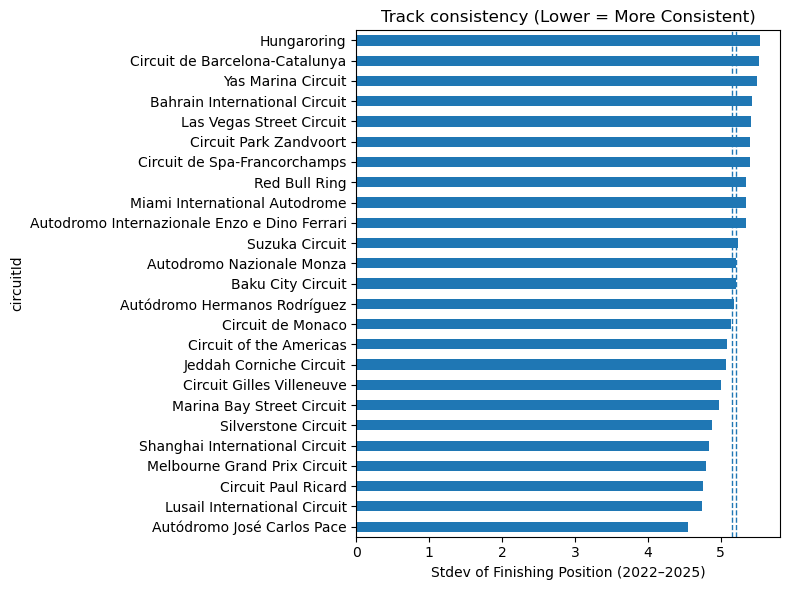

In [602]:
# map ids -> names
circuit_lookup = dict(zip(circuits_df["id"], circuits_df["fullName"]))
tc_named = track_consistency.rename(index=circuit_lookup).sort_values()

# HBAR: Track consistency
plt.figure(figsize=(8,6))
tc_named.plot(kind="barh")
m, med = tc_named.mean(), tc_named.median()
plt.axvline(m, linestyle="--", linewidth=1)
plt.axvline(med, linestyle="--", linewidth=1)
plt.xlabel("Stdev of Finishing Position (2022–2025)")
plt.title("Track consistency (Lower = More Consistent)")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

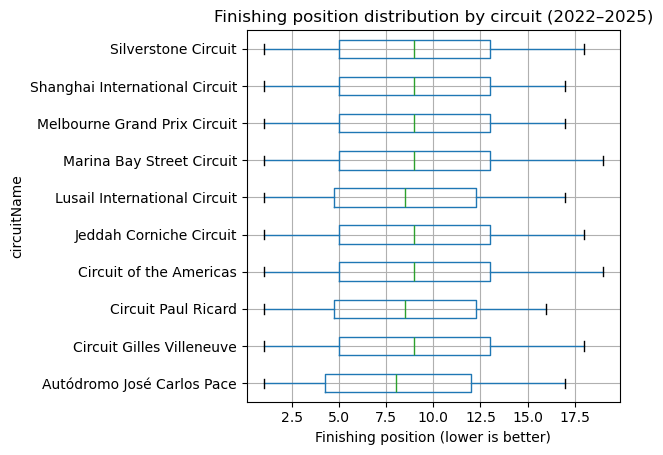

In [600]:
top = list(tc_named.head(10).index)
subset = race_results_df[race_results_df["circuitId"].map(circuit_lookup).isin(top)]
subset["circuitName"] = subset["circuitId"].map(circuit_lookup)

# BOXPLOT: Finishing position distribution by circuit
plt.figure(figsize=(10,6))
subset.boxplot(column="positionNumber", by="circuitName", vert=False)
plt.suptitle("")
plt.title("Finishing position distribution by circuit (2022–2025)")
plt.xlabel("Finishing position (lower is better)")
plt.tight_layout()
plt.show()

In [592]:
def get_contrasting_text_color(rgb):
    # luminance formula for perceived brightness
    r, g, b = rgb
    luminance = 0.299*r + 0.587*g + 0.114*b
    return "white" if luminance < 0.5 else "black"

In [976]:
from pathlib import Path

def save_chart(fig, name, fmt="png", dpi=200):
    """Save chart to /Users/showhq/Documents/GitHub/ShowsSpeed/assets"""
    outdir = Path("/Users/showhq/Documents/GitHub/ShowsSpeed/assets")
    outdir.mkdir(parents=True, exist_ok=True)
    path = outdir / f"{name}.{fmt}"
    if hasattr(fig, "savefig"):   # matplotlib
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
    elif hasattr(fig, "write_image"):  # plotly
        fig.write_image(str(path))
    else:
        raise TypeError("Unsupported figure type")
    print(f"Saved.")

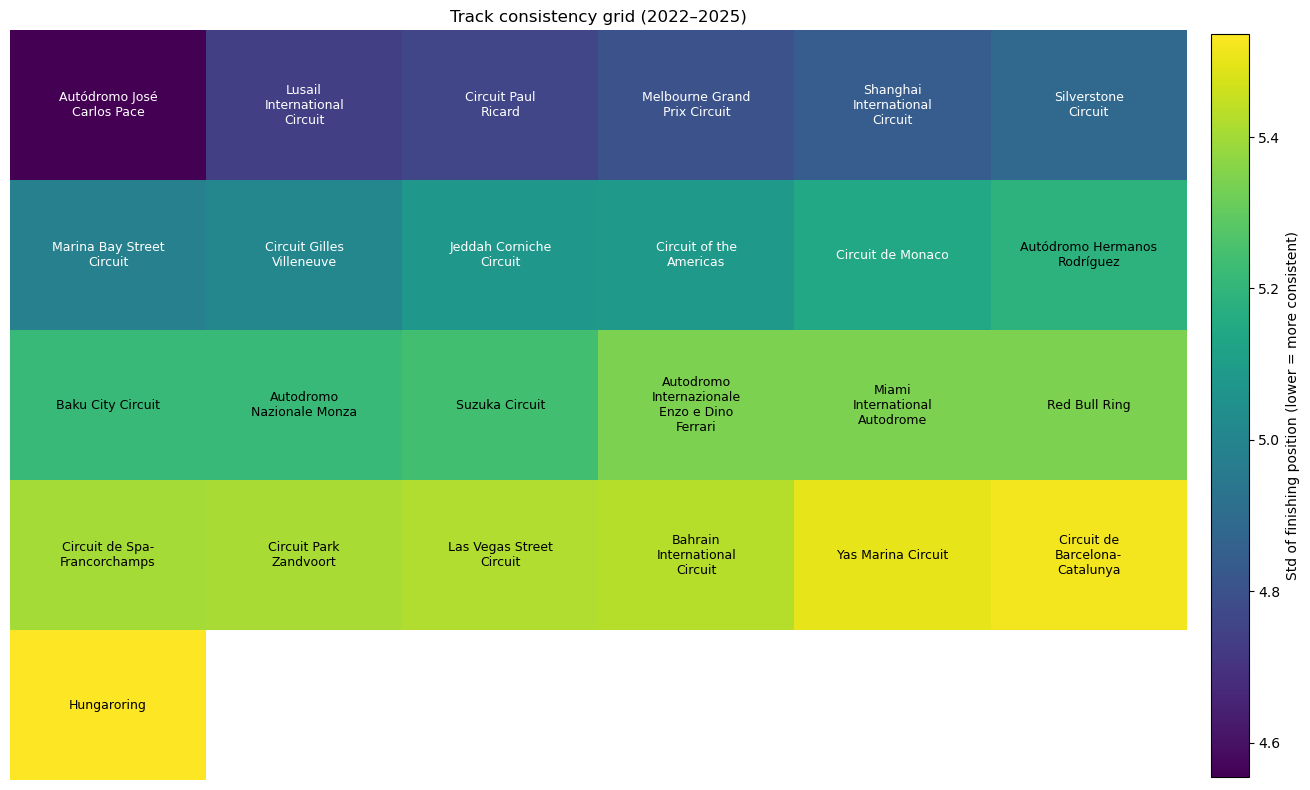

In [982]:
# Series: index=circuit names, values=std
circuit_std_series = tc_named
circuit_names = circuit_std_series.index.tolist()
circuit_std_values = circuit_std_series.values

# grid dims
num_circuits = len(circuit_std_series)
num_cols = 6
num_rows = math.ceil(num_circuits/num_cols)

# HEATMAP: Track consistency across all teams
fig, ax = plt.subplots(figsize=(num_cols*2.2, num_rows*1.6))
ax.set_xlim(0, num_cols); ax.set_ylim(0, num_rows)
ax.axis("off")
# color mapping
norm = Normalize(vmin=circuit_std_values.min(), vmax=circuit_std_values.max())
cmap = plt.cm.viridis

for i, (name, val) in enumerate(zip(circuit_names, circuit_std_values)):
    r, c = divmod(i, num_cols)
    color = cmap(norm(val))
    rect = plt.Rectangle((c, num_rows-1-r), 1, 1, facecolor=color)
    ax.add_patch(rect)

    wrapped = "\n".join(textwrap.wrap(name, width=18))
    text_color = get_contrasting_text_color(to_rgb(color))
    ax.text(c+0.5, num_rows-1-r+0.5, wrapped, ha="center", va="center",
            fontsize=9, color=text_color, wrap=True, clip_on=True)
# colorbar
sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Std of finishing position (lower = more consistent)")
plt.title("Track consistency grid (2022–2025)")
plt.tight_layout()
plt.show()
# save_chart(fig, "consistency_across_grids", fmt='png', dpi=250)

## 2. What tracks are each team's best in?

=> For each constructor, which circuits yield the strongest results relative to their own average performance?

Entailed DF's: **races, races-race-results, constructors, circuits**

In [163]:
constructors = raw_dfs["constructors"]
constructors_df = filter_recent_era(constructors)
constructors_df.head(1)

,id,name,fullName,countryId,bestChampionshipPosition,bestStartingGridPosition,bestRaceResult,totalChampionshipWins,totalRaceEntries,totalRaceStarts,totalRaceWins,total1And2Finishes,totalRaceLaps,totalPodiums,totalPodiumRaces,totalPoints,totalChampionshipPoints,totalPolePositions,totalFastestLaps
0,adams,Adams,Adams,united-states-of-america,NaN,17.0,27.0,0,1,1,0,0,108,0,0,0.0,0.0,0,0


In [165]:
print(races_df.columns)
print(race_results_df.columns)
print(constructors_df.columns)

Index(['id', 'year', 'round', 'date', 'time', 'grandPrixId', 'officialName',
       'qualifyingFormat', 'sprintQualifyingFormat', 'circuitId',
       'circuitType', 'direction', 'courseLength', 'turns', 'laps', 'distance',
       'scheduledLaps', 'scheduledDistance', 'driversChampionshipDecider',
       'constructorsChampionshipDecider', 'preQualifyingDate',
       'preQualifyingTime', 'freePractice1Date', 'freePractice1Time',
       'freePractice2Date', 'freePractice2Time', 'freePractice3Date',
       'freePractice3Time', 'freePractice4Date', 'freePractice4Time',
       'qualifying1Date', 'qualifying1Time', 'qualifying2Date',
       'qualifying2Time', 'qualifyingDate', 'qualifyingTime',
       'sprintQualifyingDate', 'sprintQualifyingTime', 'sprintRaceDate',
       'sprintRaceTime', 'warmingUpDate', 'warmingUpTime'],
      dtype='object')
Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
    

In [167]:
races_df.head(3)

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
1057,1058,2022,1,2022-03-20,NaN,bahrain,Formula 1 Gulf Air Bahrain Grand Prix 2022,KNOCKOUT,NaN,bahrain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1058,1059,2022,2,2022-03-27,NaN,saudi-arabia,Formula 1 stc Saudi Arabian Grand Prix 2022,KNOCKOUT,NaN,jeddah,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1059,1060,2022,3,2022-04-10,NaN,australia,Formula 1 Heineken Australian Grand Prix 2022,KNOCKOUT,NaN,melbourne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
race_results_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam,circuitId
25452,1058,2022,1,1,1,1,16,charles-leclerc,ferrari,ferrari,...,1.0,1,1.0,1,0.0,3.0,True,True,False,bahrain
25453,1058,2022,1,2,2,2,55,carlos-sainz-jr,ferrari,ferrari,...,3.0,3,3.0,3,1.0,3.0,False,False,False,bahrain
25454,1058,2022,1,3,3,3,44,lewis-hamilton,mercedes,mercedes,...,5.0,5,5.0,5,2.0,3.0,False,False,False,bahrain


In [171]:
team_race_results_df = (race_results_df[["raceId", "constructorId", "positionNumber"]]
                        .merge(races_df[["id", "grandPrixId"]].rename(columns={"id":"raceId"}), on="raceId", how="left")
                        .merge(constructors_df[["id", "name"]].rename(columns={"id":"constructorId"}), on="constructorId", how="left")
                        .rename(columns={"name":"team"}))[["raceId","grandPrixId","team","positionNumber"]]
team_race_results_df

,raceId,grandPrixId,team,positionNumber
0,1058,bahrain,Ferrari,1
1,1058,bahrain,Ferrari,2
2,1058,bahrain,Mercedes,3
3,1058,bahrain,Mercedes,4
4,1058,bahrain,Haas,5
...,...,...,...,...
1433,1139,hungary,Williams,15
1434,1139,hungary,Haas,16
1435,1139,hungary,Red Bull,17
1436,1139,hungary,Alpine,18


In [173]:
team_baseline = team_race_results_df.groupby("team")["positionNumber"].mean()
team_circuit = team_race_results_df.groupby(["team","grandPrixId"])["positionNumber"].mean()
print(team_baseline)
print(team_circuit)

team
Alfa Romeo      12.569444
AlphaTauri      12.750000
Alpine          10.818841
Aston Martin    10.335616
Ferrari          4.720280
Haas            13.041096
Kick Sauber     14.294118
McLaren          6.567742
Mercedes         5.597315
RB              12.428571
Racing Bulls    11.391304
Red Bull         4.582781
Williams        13.046512
Name: positionNumber, dtype: float64
team        grandPrixId  
Alfa Romeo  abu-dhabi        15.750000
            australia         9.750000
            austria          13.000000
            azerbaijan       14.500000
            bahrain          10.000000
                               ...    
Williams    sao-paulo        14.000000
            saudi-arabia     12.000000
            singapore        12.000000
            spain            17.428571
            united-states    12.500000
Name: positionNumber, Length: 308, dtype: float64


In [175]:
q2_delta = (team_circuit - team_circuit.index.get_level_values("team").map(team_baseline)).rename("delta")
q2_delta_pivot = q2_delta.reset_index().pivot(index="team", columns="grandPrixId", values="delta")
q2_delta_pivot

grandPrixId,abu-dhabi,australia,austria,azerbaijan,bahrain,belgium,canada,china,emilia-romagna,france,...,mexico,miami,monaco,netherlands,qatar,sao-paulo,saudi-arabia,singapore,spain,united-states
team,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,3.180556,-2.819444,0.430556,1.930556,-2.569444,0.430556,-2.319444,NaN,-2.569444,2.430556,...,0.430556,-0.569444,-0.319444,2.430556,-4.069444,-2.069444,1.430556,-1.069444,-1.236111,-0.236111
AlphaTauri,-1.750000,-0.500000,4.000000,-3.416667,-1.750000,-0.750000,2.583333,NaN,-3.250000,-0.750000,...,-2.750000,0.916667,1.000000,0.250000,3.250000,0.500000,-1.750000,-3.250000,-0.500000,-1.000000
Alpine,-0.018841,2.181159,0.306159,1.347826,0.752588,-0.568841,-0.568841,1.514493,3.781159,-3.818841,...,1.014493,-0.675983,-2.152174,-2.152174,-2.818841,-4.985507,-0.218841,1.181159,-1.318841,-0.018841
Aston Martin,-0.668950,-3.835616,1.664384,-0.668950,0.789384,0.039384,-1.585616,-0.002283,1.664384,0.164384,...,3.914384,2.039384,0.664384,-0.335616,-2.335616,-1.735616,-0.335616,-0.135616,0.235812,0.414384
Ferrari,0.446387,0.946387,-0.434565,2.279720,-1.434565,-0.291708,-0.220280,-0.220280,0.079720,0.279720,...,-1.053613,0.279720,-0.845280,0.079720,-0.386946,-0.220280,0.029720,-1.053613,0.994006,-2.470280
Haas,2.292237,-0.916096,-3.469667,-0.041096,-1.791096,2.458904,0.101761,-3.291096,0.158904,1.958904,...,-0.641096,0.958904,0.708904,1.125571,-0.041096,-0.707763,-1.612524,-0.374429,2.583904,-1.707763
Kick Sauber,-1.294118,-2.294118,-1.794118,0.705882,1.705882,-2.294118,-1.794118,0.039216,1.455882,NaN,...,0.205882,0.372549,0.455882,5.205882,-4.794118,-0.294118,2.705882,1.205882,-2.794118,3.705882
McLaren,-0.401075,-1.317742,1.057258,0.432258,2.575115,-0.282028,3.307258,-3.317742,-1.234409,1.432258,...,-0.067742,2.860829,-0.567742,0.932258,-2.067742,0.932258,1.432258,-2.901075,1.182258,0.032258
Mercedes,1.736018,-0.097315,-1.025887,-0.097315,-0.097315,0.402685,-2.597315,0.402685,1.802685,-3.097315,...,-1.763982,-0.097315,2.277685,1.736018,1.069351,-0.597315,0.652685,3.069351,-2.168744,-1.097315


In [584]:
# invert so higher = better (more intuitive)
team_race_results_df["score"] = -pd.to_numeric(team_race_results_df["positionNumber"], errors="coerce")
team_baseline = team_race_results_df.groupby("team")["score"].mean()
team_circuit = team_race_results_df.groupby(["team","grandPrixId"])["score"].mean()
q2_delta = (team_circuit - team_circuit.index.get_level_values("team").map(team_baseline)).rename("delta")
q2_delta_pivot = q2_delta.reset_index().pivot(index="team", columns="grandPrixId", values="delta")
q2_delta_pivot.head(1)

grandPrixId,abu-dhabi,australia,austria,azerbaijan,bahrain,belgium,canada,china,emilia-romagna,france,...,mexico,miami,monaco,netherlands,qatar,sao-paulo,saudi-arabia,singapore,spain,united-states
team,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,-3.180556,2.819444,-0.430556,-1.930556,2.569444,-0.430556,2.319444,NaN,2.569444,-2.430556,...,-0.430556,0.569444,0.319444,-2.430556,4.069444,2.069444,-1.430556,1.069444,1.236111,0.236111


## 3. Which teams are best in the dry vs the wet?

=> For each constructor, which weather condition (Dry vs Wet) yields stronger results?

- **Absolute view**: Compare mean lap-time z-scores across constructors under Dry vs Wet conditions to see which teams are outright fastest.  
- **Relative view**: For each constructor, measure the shift in their z-scores between Dry and Wet to see who adapts best relative to their own baseline.  

Entailed DF’s: **qr_2022_df, qr_2023_df, qr_2024_df, qr_2025_df, constructors, races**

Strategy: using "compound" column (tires used in that lap)

#### Absolute View:


In [392]:
qr_2022_df.head(1)

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
1,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2.0,91.471,29.367,39.067,23.037,1.0,SOFT,2.0,<NA>,<NA>,True


In [394]:
qr_2023_df.head(1)

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
2,2023,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,3.0,91.295,29.152,39.195,22.948,2.0,SOFT,3.0,<NA>,<NA>,True


In [396]:
qr_2024_df.head(1)

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
1,2024,1,Q,Bahrain Grand Prix,Qualifying,VER,1,Red Bull Racing,2.0,90.031,28.787,38.58,22.664,1.0,SOFT,2.0,<NA>,<NA>,True


In [398]:
qr_2025_df.head(1)

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,s1_s,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate
1,2025,1,Q,Australian Grand Prix,Qualifying,NOR,4,McLaren,2.0,76.003,26.383,17.285,32.335,1.0,SOFT,2.0,<NA>,<NA>,True


In [400]:
constructors = raw_dfs["constructors"]
constructors_df = filter_recent_era(constructors)
constructors_df.head(1)

,id,name,fullName,countryId,bestChampionshipPosition,bestStartingGridPosition,bestRaceResult,totalChampionshipWins,totalRaceEntries,totalRaceStarts,totalRaceWins,total1And2Finishes,totalRaceLaps,totalPodiums,totalPodiumRaces,totalPoints,totalChampionshipPoints,totalPolePositions,totalFastestLaps
0,adams,Adams,Adams,united-states-of-america,NaN,17.0,27.0,0,1,1,0,0,108,0,0,0.0,0.0,0,0


In [402]:
races_df.head(1)

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
1057,1058,2022,1,2022-03-20,NaN,bahrain,Formula 1 Gulf Air Bahrain Grand Prix 2022,KNOCKOUT,NaN,bahrain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [404]:
qr_all_df.head(1)

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate,condition,lap_z
0,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2.0,91.471,...,39.067,23.037,1.0,SOFT,2.0,<NA>,<NA>,True,Dry,-0.303749


In [576]:
team_perf_df = qr_all_df.groupby(["team", "condition"])["lap_z"].mean().reset_index()
team_perf_pivot_df = team_perf_df.pivot(index="team", columns="condition", values="lap_z")
team_perf_pivot_df

condition,Dry,Wet
team,,
Alfa Romeo,0.258687,0.675230
AlphaTauri,0.192250,0.755935
Alpine,0.152071,0.403947
Aston Martin,0.097368,0.525530
Ferrari,-0.457952,0.414836
Haas F1 Team,0.268800,0.647995
Kick Sauber,0.468270,0.598903
McLaren,-0.307753,0.298506
Mercedes,-0.385399,0.318838


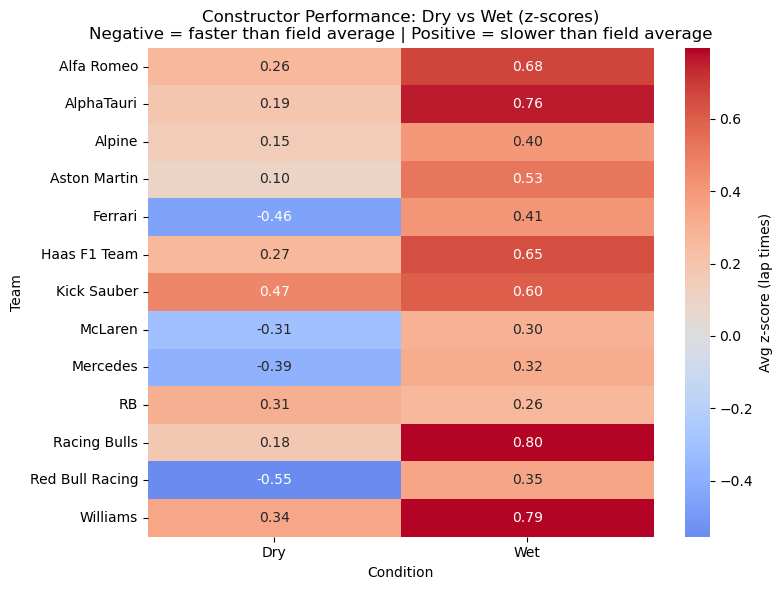

In [412]:
plt.figure(figsize=(8,6))
sns.heatmap(team_perf_pivot_df, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar_kws={'label': 'Avg z-score (lap times)'})

plt.title("Constructor Performance: Dry vs Wet (z-scores)\n"
          "Negative = faster than field average | Positive = slower than field average",
          fontsize=12)

plt.ylabel("Team")
plt.xlabel("Condition")
plt.tight_layout()
plt.show()

#### Relative View:

In [415]:
# team-only baseline: % slower/faster in wet vs own dry mean
team_cond_df = qr_all_df.groupby(["team", "condition"])["lap_time_s"].mean().reset_index()
team_cond_pivot_df = team_cond_df.pivot(index="team", columns="condition", values="lap_time_s")
team_cond_pivot_df["wet_vs_dry_pct"] = ((team_cond_pivot_df["Wet"] - team_cond_pivot_df["Dry"]) / team_cond_pivot_df["Dry"] * 100)
team_cond_pivot_df = team_cond_pivot_df.sort_values("wet_vs_dry_pct")
team_cond_pivot_df.head(10)

condition,Dry,Wet,wet_vs_dry_pct
team,,,
RB,88.895065,90.509366,1.815962
Kick Sauber,88.009074,94.711481,7.615586
Mercedes,88.321033,96.576446,9.347052
Red Bull Racing,88.363174,97.062450,9.844911
Alpine,88.690646,97.455912,9.882965
Haas F1 Team,89.741770,98.830954,10.128153
McLaren,88.277597,97.415649,10.351497
Aston Martin,88.872409,98.586555,10.930441
Ferrari,88.274514,97.965372,10.978093


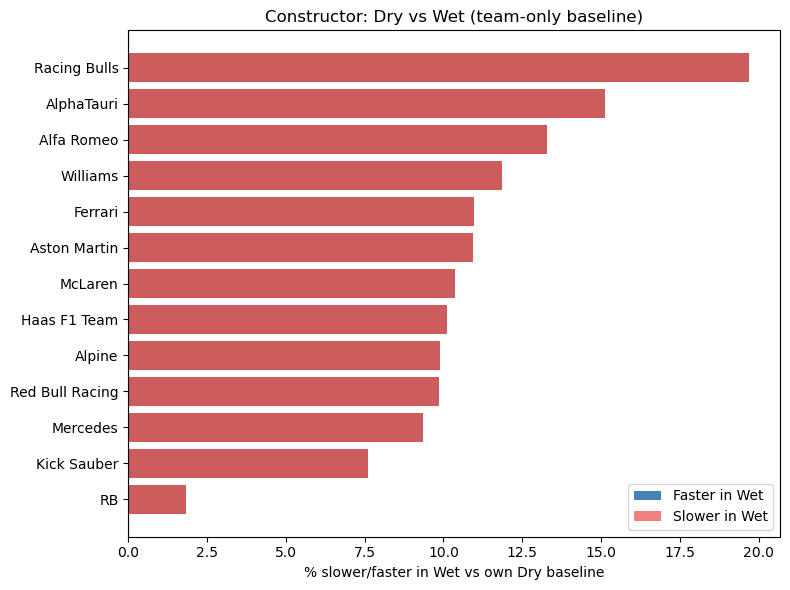

In [572]:
q3_colors = team_cond_pivot_df["wet_vs_dry_pct"].apply(lambda x: "steelblue" if x < 0 else "indianred")
# BAR: how do teams, relative to themselves, perform in the wet and dry
plt.figure(figsize=(8,6))
plt.barh(team_cond_pivot_df.index, team_cond_pivot_df["wet_vs_dry_pct"], color=q3_colors)
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("% slower/faster in Wet vs own Dry baseline")
plt.title("Constructor: Dry vs Wet (team-only baseline)")
legend_elements = [Patch(facecolor="steelblue", label="Faster in Wet"), Patch(facecolor="lightcoral", label="Slower in Wet")]
plt.legend(handles=legend_elements, loc="best")
plt.tight_layout()
plt.show()

In [568]:
# GROUPED BAR: Dry = solid, Wet = hatched (team colors)
team_colors_dct = {"Red Bull Racing": "silver",
                   "Ferrari": "red",
                   "Mercedes": "turquoise",
                   "McLaren": "orange",
                   "Aston Martin": "#006F62",
                   "Alpine": "pink",
                   "Williams": "royalblue",
                   "Kick Sauber": "lime",
                   "Haas F1 Team": "snow",
                   "RB": "darkgrey",
                   "Alfa Romeo": "#900000",
                   "AlphaTauri": "dimgrey",
                   "Racing Bulls": "lightskyblue"}

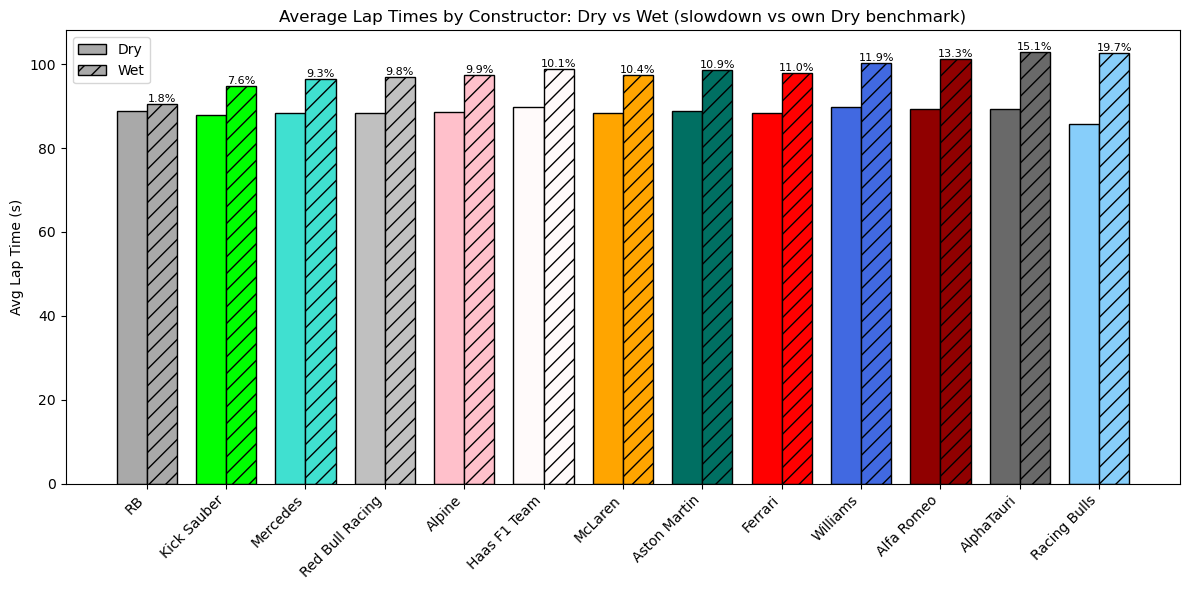

Saved.


In [1010]:
t = team_cond_pivot_df.loc[:, ["Dry","Wet","wet_vs_dry_pct"]].copy()
team_names = t.index.tolist()
x = np.arange(len(team_names)); w = 0.38

# GBAR: dry v wet perf by team
plt.figure(figsize=(12,6))
for i, team in enumerate(team_names):
    color = team_colors_dct.get(team, "gray")
    plt.bar(x[i]-w/2, t.loc[team,"Dry"], width=w, color=color, edgecolor="black", label="Dry" if i==0 else "")
    plt.bar(x[i]+w/2, t.loc[team,"Wet"], width=w, color=color, edgecolor="black", hatch="//", label="Wet" if i==0 else "")
    v = t.loc[team,"wet_vs_dry_pct"]
    plt.text(x[i]+w/2, t.loc[team,"Wet"], f"{v:.1f}%", ha="center", va="bottom", fontsize=8)
plt.xticks(x, team_names, rotation=45, ha="right")
plt.ylabel("Avg Lap Time (s)")
plt.title("Average Lap Times by Constructor: Dry vs Wet (slowdown vs own Dry benchmark)")
plt.legend()
plt.tight_layout()
plt.show()
save_chart(fig, "dry_v_wet_perf_by_team", fmt="png", dpi=250)

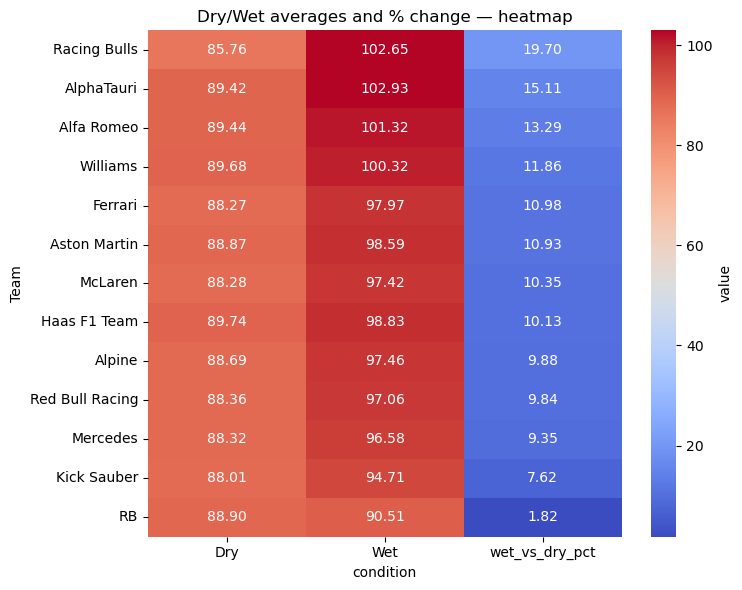

Saved.


In [1026]:
# HEATMAP: (Dry, Wet, %Δ)
team_cond_sorted_df = team_cond_pivot_df[["Dry","Wet","wet_vs_dry_pct"]].sort_values("wet_vs_dry_pct", ascending=False)
fig = plt.figure(figsize=(7.6,6))
sns.heatmap(team_cond_sorted_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label":"value"})
plt.title("Dry/Wet averages and % change — heatmap"); plt.ylabel("Team"); plt.tight_layout(); plt.show()
save_chart(fig, "dry_wet_avg_change_heatmap", fmt="png", dpi=250)

## Q4. How do pit stop strategies vary across teams and races?

=> For each constructor, which circuits/races yield the fastest average pit stop times, and how do these compare relative to their overall pit stop performance?

Entailed DF’s: **races, races-race-results, pit-stops, constructors, circuits**

In [424]:
pit_stops = raw_dfs["races-pit-stops"]
pit_stops_df = filter_recent_era(pit_stops)
pit_stops_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,stop,lap,time,timeMillis
18755,1058,2022,1,1,1,1,44,lewis-hamilton,mercedes,mercedes,pirelli,1,11,25.201,25201.0
18756,1058,2022,1,2,2,2,14,fernando-alonso,alpine,renault,pirelli,1,11,25.365,25365.0
18757,1058,2022,1,3,3,3,47,mick-schumacher,haas,ferrari,pirelli,1,12,25.214,25214.0


In [426]:
# remove outliers (above 90th %tile => when ppl mess up badly)
q_low, q_high = pit_stops_df["timeMillis"].quantile([0.05, 0.95])
pit_stops_trim = pit_stops_df[(pit_stops_df["timeMillis"] >= q_low) &
                              (pit_stops_df["timeMillis"] <= q_high)]

In [428]:
def plot_pit_times(df, year=None, ax=None):
    '''Takes a pit_time df, and plots horizontal bar chart with average & fastest pit stops, compared to an aggregated median line.'''
    d = df.copy()
    if year:
        d = d[d["year"] == year]
        title = f"Fastest Pit Crews ({year})"
    else:
        title = "Fastest Pit Crews (2022–2025)"
    if d.empty:
        ax.text(0.5, 0.5, "No data available", ha="center", va="center")
        ax.axis("off")
        return
    # per team, what's the avg. + fastest pit time?
    stats = d.groupby("constructorId")["timeMillis"].agg(["mean", "median", "min"]).sort_values("mean")
    # mean bars
    stats["mean"].plot(kind="barh", ax=ax, color="skyblue", width=0.7, label="Mean")
    ax.barh(stats.index, stats["min"], height=0.3, color="navy", label="Fastest")
    # median line: every team's average
    overall_median = d["timeMillis"].median()
    ax.axvline(overall_median, color="orange", linestyle="--", linewidth=2, label="Median")
    ax.set_xlabel("Pit Stop Time (ms)")
    ax.set_ylabel("Constructor")
    ax.set_title(title)
    ax.invert_yaxis()
    ax.legend(loc="lower right")

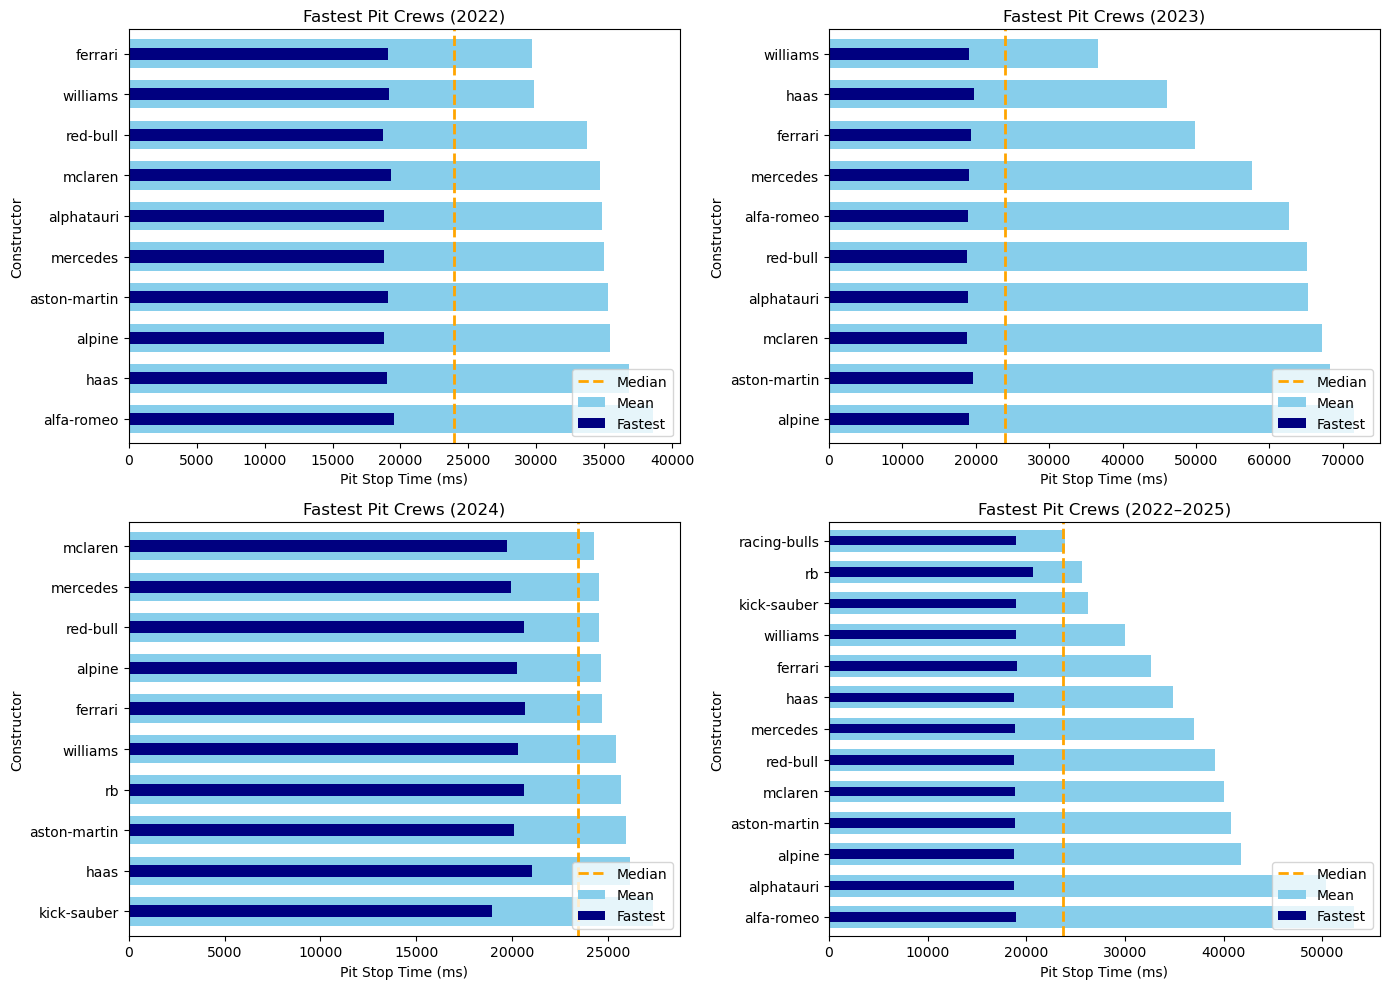

Saved.


In [1028]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
plot_pit_times(pit_stops_trim, 2022, axes[0,0]) # 2022
plot_pit_times(pit_stops_trim, 2023, axes[0,1]) # 2023
plot_pit_times(pit_stops_trim, 2024, axes[1,0]) # 2024
plot_pit_times(pit_stops_trim, None, axes[1,1]) # 2022-2025 thus far (Aug)
plt.tight_layout()
plt.show()
save_chart(fig, "pit_crews_speed", fmt="png", dpi=250)

In [432]:
# For each year, what was every team's fastest pit_stop time?
fastest_by_team_year = (pit_stops_trim.groupby(["year", "constructorId"])["timeMillis"]
                        .min().reset_index().sort_values(["year", "timeMillis"]))

for yr in sorted(fastest_by_team_year["year"].unique()):
    print(f"\n\033[1mFastest pit stop per team ({yr}):\033[0m")
    year_df = fastest_by_team_year[fastest_by_team_year["year"] == yr]
    for _, row in year_df.iterrows():
        print(f"{row['constructorId']}: {row['timeMillis']} ms")


Fastest pit stop per team (2022):
red-bull: 18738.0 ms
alphatauri: 18774.0 ms
alpine: 18796.0 ms
mercedes: 18820.0 ms
haas: 19039.0 ms
aston-martin: 19074.0 ms
ferrari: 19080.0 ms
williams: 19185.0 ms
mclaren: 19280.0 ms
alfa-romeo: 19548.0 ms

Fastest pit stop per team (2023):
red-bull: 18789.0 ms
mclaren: 18878.0 ms
alphatauri: 18904.0 ms
alfa-romeo: 18951.0 ms
williams: 19018.0 ms
alpine: 19024.0 ms
mercedes: 19146.0 ms
ferrari: 19398.0 ms
aston-martin: 19653.0 ms
haas: 19713.0 ms

Fastest pit stop per team (2024):
kick-sauber: 18938.0 ms
mclaren: 19712.0 ms
mercedes: 19954.0 ms
aston-martin: 20073.0 ms
alpine: 20257.0 ms
williams: 20287.0 ms
red-bull: 20607.0 ms
rb: 20642.0 ms
ferrari: 20671.0 ms
haas: 21035.0 ms

Fastest pit stop per team (2025):
red-bull: 18721.0 ms
haas: 18778.0 ms
aston-martin: 18802.0 ms
mercedes: 18912.0 ms
williams: 18952.0 ms
racing-bulls: 18997.0 ms
alpine: 19482.0 ms
mclaren: 19719.0 ms
ferrari: 20131.0 ms
kick-sauber: 20209.0 ms


## Q.5 How do all drivers perform during free practice, qualifying, and race day?

=> For each driver, compare best lap times across free practice, qualifying, sprint qualifying, and race sessions, showing how performance shifts across the weekend.

Entailed DF’s: **races, races-free-practice-*, races-qualifying-results, races-sprint-qualifying-results, races-fastest-laps, drivers, circuits**

In [435]:
fp1 = raw_dfs["races-free-practice-1-results"]
fp1_df = filter_recent_era(fp1)
fp1_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,time,timeMillis,gap,gapMillis,interval,intervalMillis,laps
14000,1058,2022,1,1,1,1,10,pierre-gasly,alphatauri,rbpt,pirelli,1:34.193,94193.0,NaN,NaN,NaN,NaN,23.0
14001,1058,2022,1,2,2,2,16,charles-leclerc,ferrari,ferrari,pirelli,1:34.557,94557.0,+0.364,364.0,+0.364,364.0,22.0
14002,1058,2022,1,3,3,3,55,carlos-sainz-jr,ferrari,ferrari,pirelli,1:34.611,94611.0,+0.418,418.0,+0.054,54.0,23.0


In [437]:
fp1_df.columns

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'time', 'timeMillis',
       'gap', 'gapMillis', 'interval', 'intervalMillis', 'laps'],
      dtype='object')

In [439]:
fp2 = raw_dfs["races-free-practice-2-results"]
fp2_df = filter_recent_era(fp2)
fp2_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,time,timeMillis,gap,gapMillis,interval,intervalMillis,laps
13895,1058,2022,1,1,1,1,1,max-verstappen,red-bull,rbpt,pirelli,1:31.936,91936.0,NaN,NaN,NaN,NaN,20.0
13896,1058,2022,1,2,2,2,16,charles-leclerc,ferrari,ferrari,pirelli,1:32.023,92023.0,+0.087,87.0,+0.087,87.0,20.0
13897,1058,2022,1,3,3,3,55,carlos-sainz-jr,ferrari,ferrari,pirelli,1:32.520,92520.0,+0.584,584.0,+0.497,497.0,22.0


In [441]:
fp3 = raw_dfs["races-free-practice-3-results"]
fp3_df = filter_recent_era(fp3)
fp3_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,time,timeMillis,gap,gapMillis,interval,intervalMillis,laps
7253,1058,2022,1,1,1,1,1,max-verstappen,red-bull,rbpt,pirelli,1:32.544,92544.0,NaN,NaN,NaN,NaN,15
7254,1058,2022,1,2,2,2,16,charles-leclerc,ferrari,ferrari,pirelli,1:32.640,92640.0,0.096,96.0,0.096,96.0,16
7255,1058,2022,1,3,3,3,11,sergio-perez,red-bull,rbpt,pirelli,1:32.791,92791.0,0.247,247.0,0.151,151.0,20


In [443]:
qualifying = raw_dfs["races-qualifying-results"]
qualifying_df = filter_recent_era(qualifying)
qualifying_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps
24878,1058,2022,1,1,1.0,1,16,charles-leclerc,ferrari,ferrari,...,91471.0,1:30.932,90932.0,1:30.558,90558.0,NaN,NaN,NaN,NaN,15.0
24879,1058,2022,1,2,2.0,2,1,max-verstappen,red-bull,rbpt,...,91785.0,1:30.757,90757.0,1:30.681,90681.0,+0.123,123.0,+0.123,123.0,14.0
24880,1058,2022,1,3,3.0,3,55,carlos-sainz-jr,ferrari,ferrari,...,91567.0,1:30.787,90787.0,1:30.687,90687.0,+0.129,129.0,+0.006,6.0,15.0


In [445]:
qualifying1 = raw_dfs["races-qualifying-1-results"]
qualifying1_df = filter_recent_era(qualifying1)
qualifying1_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps


In [447]:
qualifying2 = raw_dfs["races-qualifying-2-results"]
qualifying2_df = filter_recent_era(qualifying2)
qualifying2_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps


In [449]:
race_results_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam,circuitId
25452,1058,2022,1,1,1,1,16,charles-leclerc,ferrari,ferrari,...,1.0,1,1.0,1,0.0,3.0,True,True,False,bahrain
25453,1058,2022,1,2,2,2,55,carlos-sainz-jr,ferrari,ferrari,...,3.0,3,3.0,3,1.0,3.0,False,False,False,bahrain
25454,1058,2022,1,3,3,3,44,lewis-hamilton,mercedes,mercedes,...,5.0,5,5.0,5,2.0,3.0,False,False,False,bahrain


In [451]:
race_results_df.columns

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'sharedCar', 'laps',
       'time', 'timeMillis', 'timePenalty', 'timePenaltyMillis', 'gap',
       'gapMillis', 'gapLaps', 'interval', 'intervalMillis', 'reasonRetired',
       'points', 'polePosition', 'qualificationPositionNumber',
       'qualificationPositionText', 'gridPositionNumber', 'gridPositionText',
       'positionsGained', 'pitStops', 'fastestLap', 'driverOfTheDay',
       'grandSlam', 'circuitId'],
      dtype='object')

In [453]:
sprint_qualifying = raw_dfs["races-sprint-qualifying-results"]
sprint_qualifying_df = filter_recent_era(sprint_qualifying)
sprint_qualifying_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps
0,1083,2023,4,1,1.0,1,16,charles-leclerc,ferrari,ferrari,...,102820.0,1:42.500,102500.0,1:41.697,101697.0,NaN,NaN,NaN,NaN,14
1,1083,2023,4,2,2.0,2,11,sergio-perez,red-bull,honda-rbpt,...,103858.0,1:42.925,102925.0,1:41.844,101844.0,0.147,147.0,0.147,147.0,15
2,1083,2023,4,3,3.0,3,1,max-verstappen,red-bull,honda-rbpt,...,103288.0,1:42.417,102417.0,1:41.987,101987.0,0.290,290.0,0.143,143.0,13


In [455]:
sprint_qualifying_df.columns

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'time', 'timeMillis',
       'q1', 'q1Millis', 'q2', 'q2Millis', 'q3', 'q3Millis', 'gap',
       'gapMillis', 'interval', 'intervalMillis', 'laps'],
      dtype='object')

In [457]:
sprint_races = raw_dfs["races-sprint-race-results"]
sprint_races_df = filter_recent_era(sprint_races)
sprint_races_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,polePosition,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam
60,1061,2022,4,1,1.0,1,1,max-verstappen,red-bull,rbpt,...,False,1.0,1,1.0,1,0.0,NaN,False,False,False
61,1061,2022,4,2,2.0,2,16,charles-leclerc,ferrari,ferrari,...,False,2.0,2,2.0,2,0.0,NaN,False,False,False
62,1061,2022,4,3,3.0,3,11,sergio-perez,red-bull,rbpt,...,False,7.0,7,7.0,7,4.0,NaN,False,False,False


In [459]:
sprint_races_df.columns

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'sharedCar', 'laps',
       'time', 'timeMillis', 'timePenalty', 'timePenaltyMillis', 'gap',
       'gapMillis', 'gapLaps', 'interval', 'intervalMillis', 'reasonRetired',
       'points', 'polePosition', 'qualificationPositionNumber',
       'qualificationPositionText', 'gridPositionNumber', 'gridPositionText',
       'positionsGained', 'pitStops', 'fastestLap', 'driverOfTheDay',
       'grandSlam'],
      dtype='object')

In [461]:
fastest_laps = raw_dfs['races-fastest-laps']
fastest_laps_df = filter_recent_era(fastest_laps)
fastest_laps_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,lap,time,timeMillis,gap,gapMillis,interval,intervalMillis
15076,1058,2022,1,1,1,1,16,charles-leclerc,ferrari,ferrari,pirelli,51.0,1:34.570,94570,NaN,NaN,NaN,NaN
15077,1058,2022,1,2,2,2,1,max-verstappen,red-bull,rbpt,pirelli,51.0,1:35.440,95440,+0.870,870.0,+0.870,870.0
15078,1058,2022,1,3,3,3,55,carlos-sainz-jr,ferrari,ferrari,pirelli,52.0,1:35.740,95740,+1.170,1170.0,+0.300,300.0


In [463]:
drivers = raw_dfs['drivers']
drivers_df = filter_recent_era(drivers)
drivers_df.head(3)

,id,name,firstName,lastName,fullName,abbreviation,permanentNumber,gender,dateOfBirth,dateOfDeath,...,totalRaceStarts,totalRaceWins,totalRaceLaps,totalPodiums,totalPoints,totalChampionshipPoints,totalPolePositions,totalFastestLaps,totalDriverOfTheDay,totalGrandSlams
0,adderly-fong,Adderly Fong,Adderly,Fong,Adderly Fong Cheun-yue,FON,NaN,MALE,1990-03-02,NaN,...,0,0,0,0,0.0,0.0,0,0,0,0
1,adolf-brudes,Adolf Brudes,Adolf,Brudes,Adolf Brudes von Breslau,BRU,NaN,MALE,1899-10-15,1986-11-05,...,1,0,5,0,0.0,0.0,0,0,0,0
2,adolfo-schwelm-cruz,Adolfo Schwelm Cruz,Adolfo,Schwelm Cruz,Adolfo Julio Carlos Schwelm Cruz,SCH,NaN,MALE,1923-06-28,2012-02-10,...,1,0,20,0,0.0,0.0,0,0,0,0


#### Setting up circuits_df so name customization is possible:

In [466]:
circuits = raw_dfs['circuits']
circuits_df = filter_recent_era(circuits)
circuits_df.head(3)

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.780,16,11
1,aida,Aida,Okayama International Circuit,TI Circuit Aida,RACE,CLOCKWISE,Aida,japan,34.915000,134.221111,3.703,13,2
2,ain-diab,Ain-Diab,Ain-Diab Circuit,NaN,ROAD,CLOCKWISE,Casablanca,morocco,33.578611,-7.687500,7.618,18,1


In [468]:
# use fastest laps as the source of laps_df
laps_df = raw_dfs['races-fastest-laps']
laps_df = filter_recent_era(laps_df)
laps_df.head(3)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,lap,time,timeMillis,gap,gapMillis,interval,intervalMillis
15076,1058,2022,1,1,1,1,16,charles-leclerc,ferrari,ferrari,pirelli,51.0,1:34.570,94570,NaN,NaN,NaN,NaN
15077,1058,2022,1,2,2,2,1,max-verstappen,red-bull,rbpt,pirelli,51.0,1:35.440,95440,+0.870,870.0,+0.870,870.0
15078,1058,2022,1,3,3,3,55,carlos-sainz-jr,ferrari,ferrari,pirelli,52.0,1:35.740,95740,+1.170,1170.0,+0.300,300.0


In [470]:
# Get best free practice, qualifying, sprint qualifying, and race laptimes
def best_fp(fp_list):
    fp = pd.concat(
        [d[["raceId","driverId","timeMillis"]].rename(columns={"timeMillis":"fpMs"})
         for d in fp_list],
        ignore_index=True)
    return (fp.groupby(["raceId","driverId"], as_index=False)["fpMs"]
              .min().rename(columns={"fpMs":"fp_best"}))

In [472]:
def best_quali(qual_df):
    cols = [c for c in ["q1Millis","q2Millis","q3Millis","timeMillis"] if c in qual_df.columns]
    q = qual_df[["raceId","driverId"] + cols].copy()
    q["quali_best"] = q[cols].min(axis=1, skipna=True)
    return q.groupby(["raceId","driverId"], as_index=False)["quali_best"].min()

In [474]:
def best_sprint_quali(sq_df):
    cols = [c for c in ["q1Millis","q2Millis","q3Millis","timeMillis"] if c in sq_df.columns]
    sq = sq_df[["raceId","driverId"] + cols].copy()
    sq["sprint_quali_best"] = sq[cols].min(axis=1, skipna=True)
    return sq.groupby(["raceId","driverId"], as_index=False)["sprint_quali_best"].min()

In [476]:
def best_race_fastlap(fastest_laps_df=None, lap_times_df=None):
    # prefer fastest-laps table if provided; else derive from lap-times
    if fastest_laps_df is not None:
        col = "timeMillis" if "timeMillis" in fastest_laps_df.columns else "milliseconds"
        r = fastest_laps_df[["raceId","driverId", col]].rename(columns={col:"race_best"})
        return r.groupby(["raceId","driverId"], as_index=False)["race_best"].min()
    # fallback uses lap-times
    col = "timeMillis" if "timeMillis" in lap_times_df.columns else "milliseconds"
    r = lap_times_df[["raceId","driverId", col]].rename(columns={col:"race_best"})
    return r.groupby(["raceId","driverId"], as_index=False)["race_best"].min()

In [478]:
def build_driver_laptime_breakdown(fp1_df, fp2_df, fp3_df,
                                   qualifying_df,
                                   sprint_qualifying_df,
                                   fastest_laps_df=None,
                                   lap_times_df=None):
    fp_best  = best_fp([fp1_df, fp2_df, fp3_df])
    q_best   = best_quali(qualifying_df)
    sq_best  = best_sprint_quali(sprint_qualifying_df)
    r_best   = best_race_fastlap(fastest_laps_df, lap_times_df)
    out = (fp_best.merge(q_best, on=["raceId","driverId"], how="outer")
                 .merge(sq_best, on=["raceId","driverId"], how="outer")
                 .merge(r_best, on=["raceId","driverId"], how="outer"))
    return out

In [480]:
def plot_driver_breakdown_for_race(df, raceId, drivers_df=None, top_n=None):
    d = df[df["raceId"] == raceId].copy()
    # label with driver names if available
    if drivers_df is not None and {"id","fullName"}.issubset(drivers_df.columns):
        name_map = dict(zip(drivers_df["id"], drivers_df["fullName"]))
        d["label"] = d["driverId"].map(name_map).fillna(d["driverId"])
    else:
        d["label"] = d["driverId"]
    cols = [c for c in ["fp_best","sprint_quali_best","quali_best","race_best"] if c in d.columns]
    d = d[["label"] + cols].set_index("label")
    if "quali_best" in d.columns and top_n:
        d = d.sort_values("quali_best").head(top_n)
    # convert ms -> s
    d = d / 1000.0
    # plot
    ax = d.plot(kind="bar", figsize=(12,6))
    ax.set_ylabel("Lap time (s)")
    ax.set_title(f"Driver Lap-time Breakdown – raceId {raceId}")
    plt.xticks(rotation=45, ha="right")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [482]:
def race_info(races_df, circuits_df, race_id):
    '''Return (circuit_name, year) for a given race_id.
    Merges races_df and circuits_df under the hood.'''
    # normalize keys
    r = races_df.rename(columns={"id": "raceId"})
    c = circuits_df.rename(columns={"id": "circuitId"}).copy()
    c["circuit_name"] = c.get("fullName").fillna(c.get("name"))
    # find corresponding circuit and year
    lookup = r[["raceId", "year", "circuitId"]].merge(
        c[["circuitId", "circuit_name"]], on="circuitId", how="left")
    row = lookup.loc[lookup["raceId"] == race_id]
    if row.empty:
        return f"raceId {race_id}", None
    row = row.iloc[0]
    print(row["circuit_name"], int(row["year"]))

In [484]:
def race_ids_for_circuit(races_df, circuit_id):
    """Return a DataFrame of all raceIds (and years) that ran on circuit_id."""
    r = races_df.rename(columns={"id": "raceId"})
    return r.loc[r["circuitId"] == circuit_id, ["raceId", "year"]].sort_values("year")

def race_id_for_circuit_year(races_df, circuit_id, year):
    """Return the single raceId for a given circuit_id and year."""
    r = races_df.rename(columns={"id": "raceId"})
    return int(r.loc[(r["circuitId"] == circuit_id) & (r["year"] == year), "raceId"].iloc[0])

In [486]:
# test: all Bahrain raceIds – sweet
race_ids_for_circuit(races_df, "bahrain")

,raceId,year
1057,1058,2022
1079,1080,2023
1101,1102,2024
1128,1129,2025


In [488]:
race_ids_for_circuit(races_df, "spa-francorchamps")

,raceId,year
1070,1071,2022
1090,1091,2023
1114,1115,2024
1137,1138,2025


In [490]:
# Build driver lap-time breakdowns & plot performance across sessions for selected races
lap_df = build_driver_laptime_breakdown(fp1_df, fp2_df, fp3_df, qualifying_df, sprint_qualifying_df, fastest_laps_df=laps_df, lap_times_df=None)         

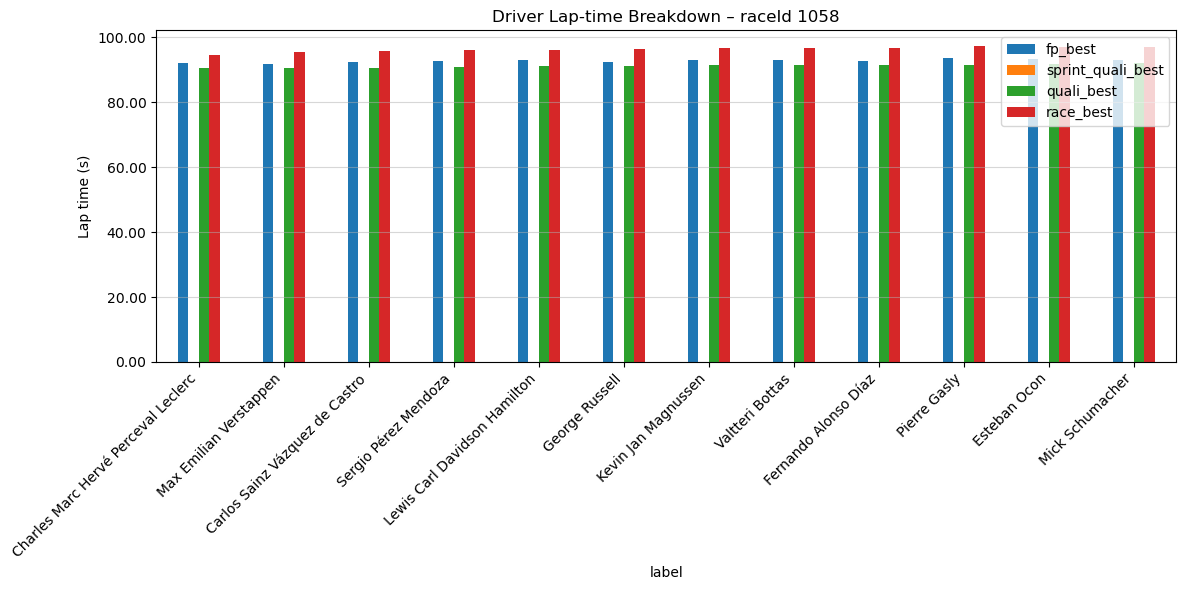

Bahrain International Circuit 2022


In [492]:
plot_driver_breakdown_for_race(lap_df, raceId=1058, drivers_df=drivers_df, top_n=12)
race_info(races_df, circuits_df, 1058)

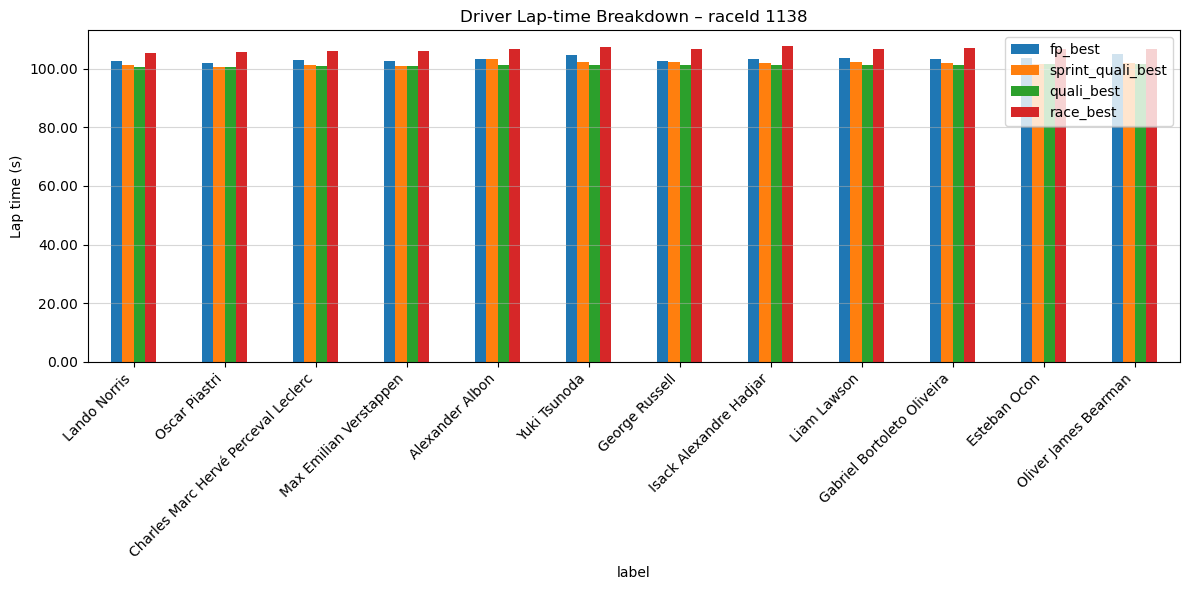

Circuit de Spa-Francorchamps 2025


In [494]:
plot_driver_breakdown_for_race(lap_df, raceId=1138, drivers_df=drivers_df, top_n=12)
race_info(races_df, circuits_df, 1138)

## Q.6 Who chokes under pressure?
=> Which teams or drivers lose the most ground from qualifying to race finish, relative to their own typical race?

In [497]:
print(race_results_df.columns)
race_results_df.head(1)

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'sharedCar', 'laps',
       'time', 'timeMillis', 'timePenalty', 'timePenaltyMillis', 'gap',
       'gapMillis', 'gapLaps', 'interval', 'intervalMillis', 'reasonRetired',
       'points', 'polePosition', 'qualificationPositionNumber',
       'qualificationPositionText', 'gridPositionNumber', 'gridPositionText',
       'positionsGained', 'pitStops', 'fastestLap', 'driverOfTheDay',
       'grandSlam', 'circuitId'],
      dtype='object')


,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam,circuitId
25452,1058,2022,1,1,1,1,16,charles-leclerc,ferrari,ferrari,...,1.0,1,1.0,1,0.0,3.0,True,True,False,bahrain


In [499]:
# overtakes per team => finish - starting position
race_results_df["delta"] = race_results_df["positionNumber"] - race_results_df["gridPositionNumber"]

constructor_delta = (race_results_df.groupby("constructorId")["delta"].mean().sort_values())

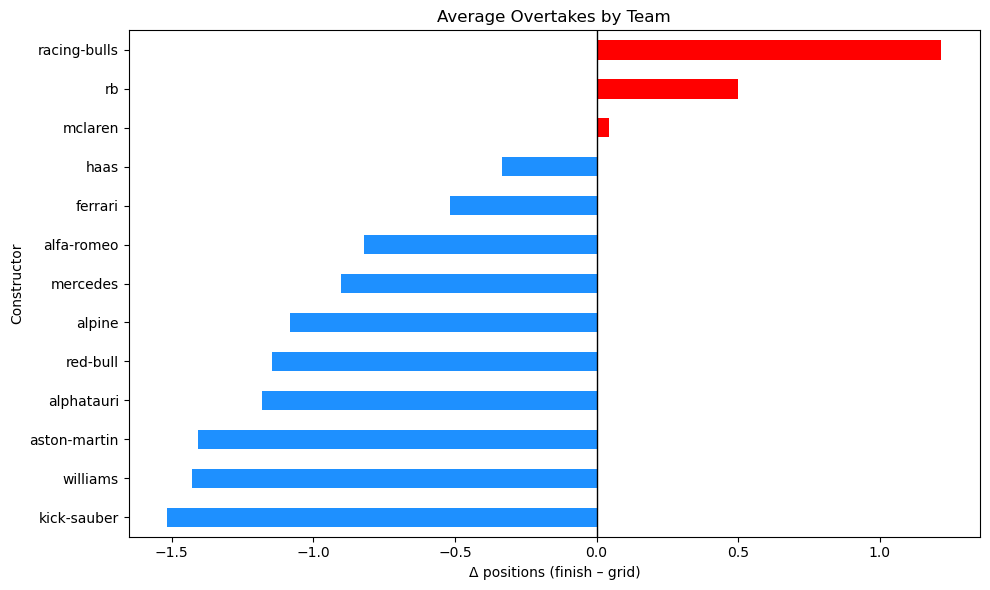

Saved.


In [1030]:
# plot
fig = plt.figure(figsize=(10,6))
colors = constructor_delta.apply(lambda x: "dodgerblue" if x < 0 else "red")
constructor_delta.plot(kind="barh", color=colors)

plt.axvline(0, color="black", linewidth=1)
plt.title("Average Overtakes by Team")
plt.xlabel("Δ positions (finish – grid)")
plt.ylabel("Constructor")
plt.tight_layout()
plt.show()
save_chart(fig, "avg_overtakes_by_team", fmt="png", dpi=250)

## Q.7 Who gambles with pit stops — and wins?

=> 1) Flag outlier pit strategies within each race (early undercut, late overcut, tire-stretch, one-stop outlier, uncommon compound) and 2) test if those "gambles" beat the race’s median finish percentile

Entailed DF’s: **qr_all_df, races-race-results, drivers, constructors**

In [629]:
print(qr_all_df.columns)
qr_all_df.head(1)

Index(['year', 'round', 'session_type', 'event_name', 'session_name', 'driver',
       'driver_number', 'team', 'lap', 'lap_time_s', 's1_s', 's2_s', 's3_s',
       'stint', 'compound', 'tyre_life', 'is_pit_out', 'is_pit_in',
       'is_accurate', 'condition', 'lap_z'],
      dtype='object')


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate,condition,lap_z
0,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2.0,91.471,...,39.067,23.037,1.0,SOFT,2.0,<NA>,<NA>,True,Dry,-0.303749


In [632]:
print(race_results_df.columns)
race_results_df.head(1)

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'sharedCar', 'laps',
       'time', 'timeMillis', 'timePenalty', 'timePenaltyMillis', 'gap',
       'gapMillis', 'gapLaps', 'interval', 'intervalMillis', 'reasonRetired',
       'points', 'polePosition', 'qualificationPositionNumber',
       'qualificationPositionText', 'gridPositionNumber', 'gridPositionText',
       'positionsGained', 'pitStops', 'fastestLap', 'driverOfTheDay',
       'grandSlam', 'circuitId', 'delta'],
      dtype='object')


,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam,circuitId,delta
25452,1058,2022,1,1,1,1,16,charles-leclerc,ferrari,ferrari,...,1,1.0,1,0.0,3.0,True,True,False,bahrain,0.0


In [634]:
print(drivers_df.columns)
drivers_df.head(1)

Index(['id', 'name', 'firstName', 'lastName', 'fullName', 'abbreviation',
       'permanentNumber', 'gender', 'dateOfBirth', 'dateOfDeath',
       'placeOfBirth', 'countryOfBirthCountryId', 'nationalityCountryId',
       'secondNationalityCountryId', 'bestChampionshipPosition',
       'bestStartingGridPosition', 'bestRaceResult', 'totalChampionshipWins',
       'totalRaceEntries', 'totalRaceStarts', 'totalRaceWins', 'totalRaceLaps',
       'totalPodiums', 'totalPoints', 'totalChampionshipPoints',
       'totalPolePositions', 'totalFastestLaps', 'totalDriverOfTheDay',
       'totalGrandSlams'],
      dtype='object')


,id,name,firstName,lastName,fullName,abbreviation,permanentNumber,gender,dateOfBirth,dateOfDeath,...,totalRaceStarts,totalRaceWins,totalRaceLaps,totalPodiums,totalPoints,totalChampionshipPoints,totalPolePositions,totalFastestLaps,totalDriverOfTheDay,totalGrandSlams
0,adderly-fong,Adderly Fong,Adderly,Fong,Adderly Fong Cheun-yue,FON,NaN,MALE,1990-03-02,NaN,...,0,0,0,0,0.0,0.0,0,0,0,0


In [636]:
print(constructors_df.columns)
constructors_df.head(1)

Index(['id', 'name', 'fullName', 'countryId', 'bestChampionshipPosition',
       'bestStartingGridPosition', 'bestRaceResult', 'totalChampionshipWins',
       'totalRaceEntries', 'totalRaceStarts', 'totalRaceWins',
       'total1And2Finishes', 'totalRaceLaps', 'totalPodiums',
       'totalPodiumRaces', 'totalPoints', 'totalChampionshipPoints',
       'totalPolePositions', 'totalFastestLaps'],
      dtype='object')


,id,name,fullName,countryId,bestChampionshipPosition,bestStartingGridPosition,bestRaceResult,totalChampionshipWins,totalRaceEntries,totalRaceStarts,totalRaceWins,total1And2Finishes,totalRaceLaps,totalPodiums,totalPodiumRaces,totalPoints,totalChampionshipPoints,totalPolePositions,totalFastestLaps
0,adams,Adams,Adams,united-states-of-america,NaN,17.0,27.0,0,1,1,0,0,108,0,0,0.0,0.0,0,0


In [646]:
# Get each driver's strategy per race
pit_summary = (qr_all_df.query("session_type == 'R'") 
               .groupby(["year", "round", "driver_number", "driver", "team"])
               .agg(total_stops=("is_pit_in", "sum"),
                    first_stop_lap=("lap", lambda x: x[x > 1].min(skipna=True)),
                    last_stop_lap=("lap", "max"),
                    longest_stint=("stint", "max"),
                    stint_count=("stint", "nunique"),
        compound_seq=("compound", lambda x: "-".join(x.dropna().unique()))).reset_index())
pit_summary.head(3)

,year,round,driver_number,driver,team,total_stops,first_stop_lap,last_stop_lap,longest_stint,stint_count,compound_seq
0,2022,1,1,VER,Red Bull Racing,0,2.0,53.0,4.0,4,SOFT-MEDIUM
1,2022,1,3,RIC,McLaren,0,2.0,57.0,4.0,4,MEDIUM-SOFT-HARD
2,2022,1,4,NOR,McLaren,0,2.0,57.0,4.0,4,MEDIUM-HARD-SOFT


In [650]:
# classify gambles as outlier pit strategies
def flag_gambles(g):
  q25 = g["first_stop_lap"].quantile(0.25)
  q75 = g["first_stop_lap"].quantile(0.75)
  stint_q75 = g["longest_stint"].quantile(0.75)
  med_stints = g["stint_count"].median()
  g["early_undercut"] = g["first_stop_lap"]<=q25
  g["late_overcut"] = g["first_stop_lap"]>=q75
  g["tire_stretch"] = g["longest_stint"]>=stint_q75
  g["one_stop_outlier"] = (g["stint_count"]==1) & (med_stints>1)
  return g

pit_summary = pit_summary.groupby(["year","round"], group_keys=False).apply(flag_gambles)
pit_summary.head(1)

,year,round,driver_number,driver,team,total_stops,first_stop_lap,last_stop_lap,longest_stint,stint_count,compound_seq,early_undercut,late_overcut,tire_stretch,one_stop_outlier
0,2022,1,1,VER,Red Bull Racing,0,2.0,53.0,4.0,4,SOFT-MEDIUM,True,True,True,False


In [662]:
# Merging results & finish percentile
res_slim = race_results_df.rename(columns={"driverNumber":"driver_number"})[["year","round","driver_number","positionNumber"]].copy()
pit_results = pit_summary.merge(res_slim, on=["year","round","driver_number"], how="left")
pit_results["field_size"] = pit_results.groupby(["year","round"])["positionNumber"].transform("max")
pit_results["finish_pct"] = 1 - (pit_results["positionNumber"]-1)/(pit_results["field_size"]-1)
pit_results.head(1)

,year,round,driver_number,driver,team,total_stops,first_stop_lap,last_stop_lap,longest_stint,stint_count,compound_seq,early_undercut,late_overcut,tire_stretch,one_stop_outlier,positionNumber,field_size,finish_pct
0,2022,1,1,VER,Red Bull Racing,0,2.0,53.0,4.0,4,SOFT-MEDIUM,True,True,True,False,19.0,19.0,0.0


In [687]:
# Long Format & Driver Success Table
gamble_cols = ["early_undercut","late_overcut","tire_stretch","one_stop_outlier"]
gamble_long = pit_results.melt(id_vars=["year","round","driver","team","finish_pct"],
                               value_vars=gamble_cols,
                               var_name="gamble_type", value_name="is_gamble")
gamble_long = gamble_long.query("is_gamble")
gamble_success = (gamble_long.groupby(["driver","team","gamble_type"])
                  .agg(avg_finish=("finish_pct","mean"), n=("finish_pct","count"))
                  .reset_index()
                  .sort_values(["gamble_type","avg_finish"], ascending=[True,False]))

# TABLE: Top 10 per gamble
top10_gambles = gamble_success.groupby("gamble_type").head(10)
top10_gambles.head(12)

,driver,team,gamble_type,avg_finish,n
167,VER,Red Bull Racing,early_undercut,0.907318,72
93,LEC,Ferrari,early_undercut,0.812894,66
138,SAI,Ferrari,early_undercut,0.761052,52
117,PER,Red Bull Racing,early_undercut,0.741395,57
64,HAM,Mercedes,early_undercut,0.740614,59
105,NOR,McLaren,early_undercut,0.731277,72
135,RUS,Mercedes,early_undercut,0.730206,72
121,PIA,McLaren,early_undercut,0.711275,52
61,HAM,Ferrari,early_undercut,0.659802,13
15,BEA,Ferrari,early_undercut,0.647059,1


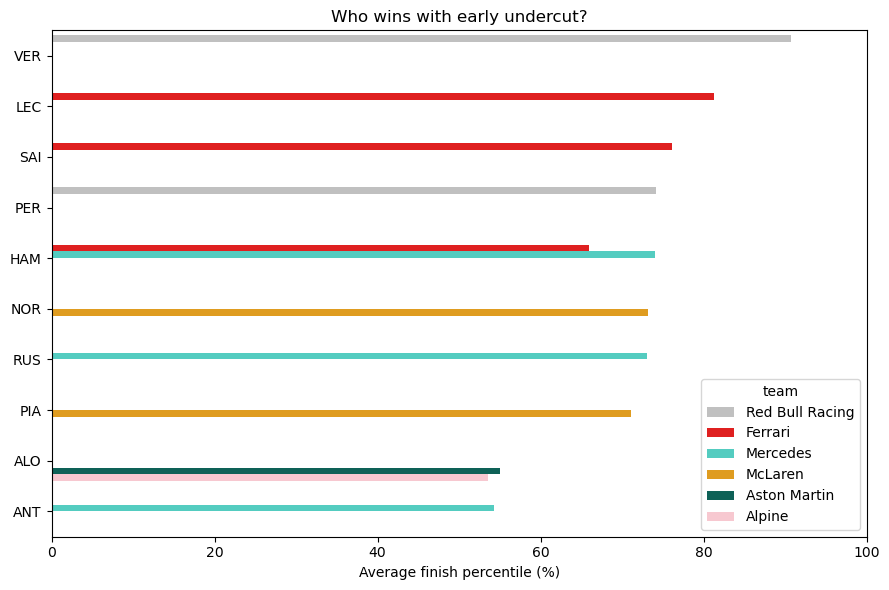

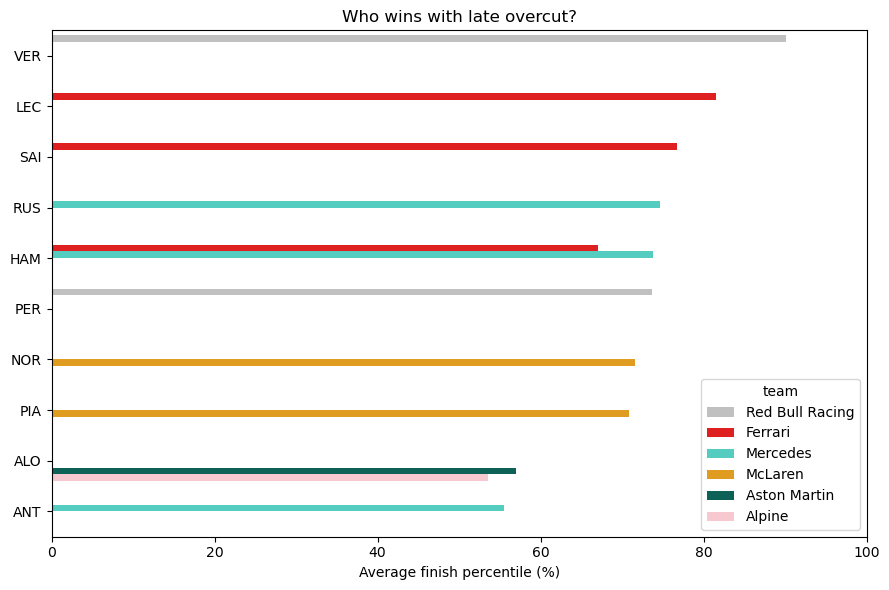

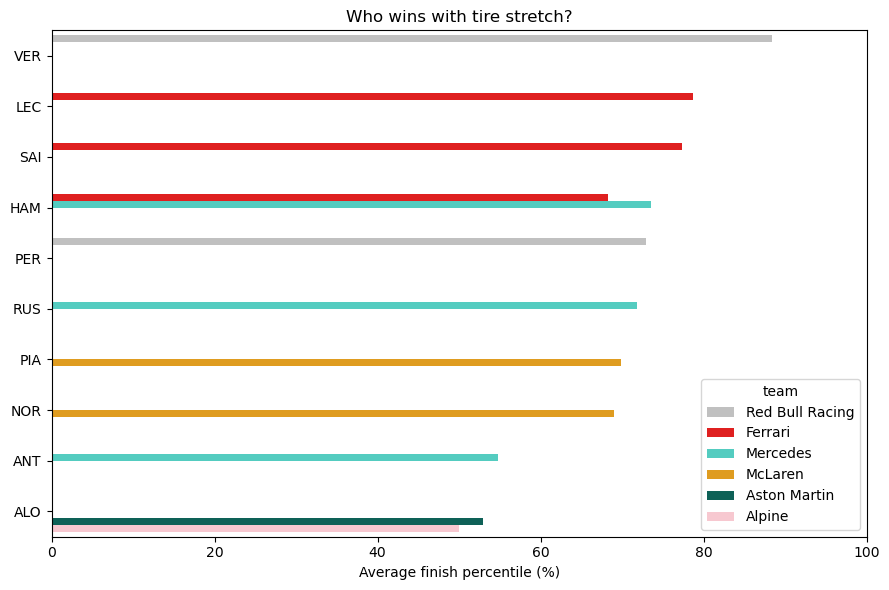

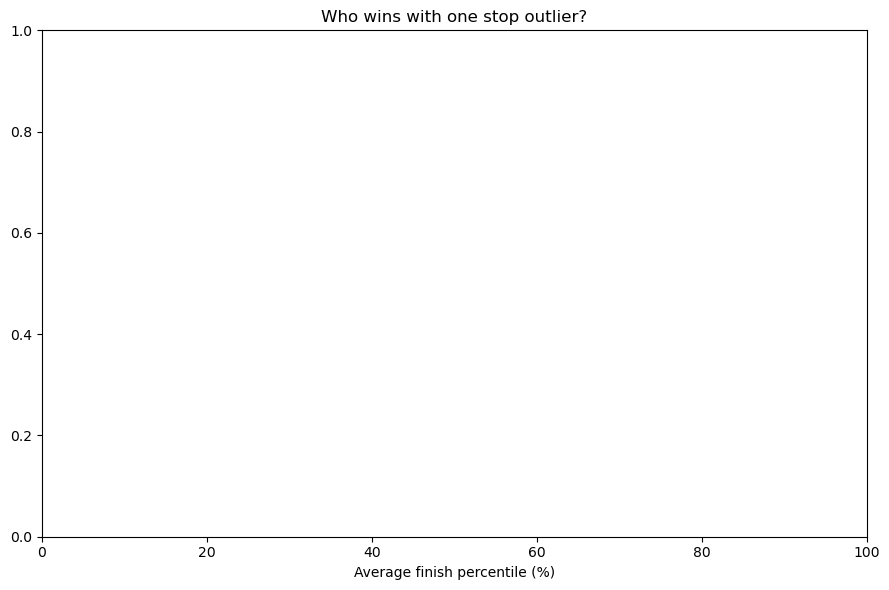

Saved.


In [1032]:
# HBAR: Most successful drivers, descneding, per "gamble" strategy, team included
for gtype in gamble_cols:
    q7_d = gamble_success.query("gamble_type==@gtype & n>=3").head(12)
    q7_d = q7_d.assign(avg_finish_pct = q7_d["avg_finish"]*100)
    fig = plt.figure(figsize=(9,6))
    sns.barplot(data=q7_d, x="avg_finish_pct", y="driver", hue="team", palette=team_colors_dct) # this color dict is from earlier
    plt.title(f"Who wins with {gtype.replace('_',' ')}?")
    plt.xlabel("Average finish percentile (%)")
    plt.ylabel("")
    plt.xlim(0,100)
    plt.tight_layout()
    plt.show()
save_chart(fig, "gamble_strats_success_margin", fmt="png", dpi=250)

## Q.8 Does home advantage exist in F1?

=> Do drivers or constructors perform better at their home races compared to their average performance across all races?

Entailed DF’s: **races, circuits, drivers, constructors, races-race-results**

In [506]:
circuits_df.head(1)

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.78,16,11


In [508]:
print(circuits_df["name"].unique())

['Adelaide' 'Aida' 'Ain-Diab' 'Aintree' 'Anderstorp Raceway' 'Americas'
 'AVUS' 'Bahrain' 'Baku' 'Brands Hatch' 'Bremgarten' 'Buddh'
 'Juan y Oscar Gálvez' 'Bugatti' 'Caesars Palace' 'Catalunya' 'Charade'
 'Fair Park' 'Detroit' 'Dijon-Prenois' 'Donington Park' 'Prince George'
 'Estoril' 'Fuji' 'Hockenheimring' 'Hungaroring' 'Enzo e Dino Ferrari'
 'Indianapolis' 'José Carlos Pace' 'Istanbul Park' 'Nelson Piquet'
 'Jarama' 'Jeddah' 'Jerez' 'Kyalami' 'Las Vegas' 'Long Beach' 'Lusail'
 'Magny-Cours' 'Marina Bay' 'Melbourne' 'Hermanos Rodríguez' 'Miami'
 'Monaco' 'Monsanto' 'Mont-Tremblant' 'Montjuïc' 'Gilles Villeneuve'
 'Monza' 'Mosport' 'Mugello' 'Nivelles-Baulers' 'Nürburgring'
 'Paul Ricard' 'Pedralbes' 'Pescara' 'Phoenix' 'Portimão' 'Boavista'
 'Reims-Gueux' 'Riverside' 'Rouen-Les-Essarts' 'Sebring' 'Sepang'
 'Shanghai' 'Silverstone' 'Sochi' 'Spa-Francorchamps' 'Red Bull Ring'
 'Suzuka' 'Valencia' 'Watkins Glen' 'Yas Marina' 'Korea' 'Zandvoort'
 'Zeltweg' 'Zolder']


In [510]:
seasons_drivers = raw_dfs["seasons-drivers"]
seasons_drivers_df = filter_recent_era(seasons_drivers)
seasons_drivers_df.head(3)

,year,driverId,positionNumber,positionText,bestStartingGridPosition,bestRaceResult,totalRaceEntries,totalRaceStarts,totalRaceWins,totalRaceLaps,totalPodiums,totalPoints,totalPolePositions,totalFastestLaps,totalDriverOfTheDay,totalGrandSlams
3249,2022,guanyu-zhou,18.0,18,9.0,8.0,22,22,0,1060,0,6.0,0,1,0,0
3250,2022,valtteri-bottas,10.0,10,5.0,5.0,22,22,0,1136,0,49.0,0,0,0,0
3251,2022,robert-kubica,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0,0,0,0


In [512]:
print(seasons_drivers_df["driverId"].unique())

['guanyu-zhou' 'valtteri-bottas' 'robert-kubica' 'theo-pourchaire'
 'lance-stroll' 'nico-hulkenberg' 'sebastian-vettel' 'nyck-de-vries'
 'felipe-drugovich' 'esteban-ocon' 'fernando-alonso' 'jack-doohan'
 'kevin-magnussen' 'mick-schumacher' 'antonio-giovinazzi'
 'pietro-fittipaldi' 'daniel-ricciardo' 'lando-norris' 'alex-palou'
 'patricio-oward' 'george-russell' 'lewis-hamilton' 'max-verstappen'
 'sergio-perez' 'juri-vips' 'liam-lawson' 'pierre-gasly' 'yuki-tsunoda'
 'carlos-sainz-jr' 'charles-leclerc' 'robert-shwartzman' 'alexander-albon'
 'nicholas-latifi' 'logan-sargeant' 'oscar-piastri' 'frederik-vesti'
 'oliver-bearman' 'isack-hadjar' 'jake-dennis' 'zak-osullivan'
 'ryo-hirakawa' 'andrea-kimi-antonelli' 'arthur-leclerc' 'ayumu-iwasa'
 'franco-colapinto' 'luke-browning' 'victor-martins' 'alexander-dunne'
 'arvid-lindblad' 'dino-beganovic' 'gabriel-bortoleto' 'paul-aron']


In [621]:
drivers_homebase_df = seasons_drivers_df[["driverId","year"]].drop_duplicates()
drivers_homebase_df["home_circuitId"] = None

In [623]:
# manual mapping: each driver to home circuit (if applicable)
homebase_map = {"charles-leclerc": "Monaco",
                "fernando-alonso": "Catalunya",
                "carlos-sainz-jr": "Catalunya",
                "lewis-hamilton": "Silverstone",
                "george-russell": "Silverstone",
                "lando-norris": "Silverstone",
                "alexander-albon": "Silverstone",
                "max-verstappen": "Zandvoort",
                "nyck-de-vries": "Zandvoort",
                "guanyu-zhou": "Shanghai",
                "valtteri-bottas": "None",
                "kimi-raikkonen": "Hockenheimring",
                "sebastian-vettel": "Hockenheimring",
                "nico-hulkenberg": "Hockenheimring",
                "mick-schumacher": "Hockenheimring",
                "kevin-magnussen": "Anderstorp Raceway",
                "oscar-piastri": "Melbourne",
                "daniel-ricciardo": "Melbourne",
                "sergio-perez": "Hermanos Rodríguez",
                "lance-stroll": "Gilles Villeneuve",
                "nicholas-latifi": "Gilles Villeneuve",
                "esteban-ocon": "Paul Ricard",
                "pierre-gasly": "Paul Ricard",
                "yuki-tsunoda": "Suzuka",
                "ayumu-iwasa": "Suzuka",
                "robert-kubica": "None", 
                "antonio-giovinazzi": "Monza",
                "frederik-vesti": "Anderstorp Raceway",
                "theo-pourchaire": "Paul Ricard",
                "logon-sargeant": "Indianapolis"}

In [625]:
drivers_homebase_df["home_circuitId"] = drivers_homebase_df["driverId"].map(homebase_map)
drivers_homebase_df = drivers_homebase_df.merge(circuits_df[["id"]],
                                                left_on="home_circuitId", right_on="id", how="left").drop(columns=["id"])
drivers_homebase_df

,driverId,year,home_circuitId
0,guanyu-zhou,2022,Shanghai
1,valtteri-bottas,2022,None
2,robert-kubica,2022,None
3,theo-pourchaire,2022,Paul Ricard
4,lance-stroll,2022,Gilles Villeneuve
...,...,...,...
125,dino-beganovic,2025,NaN
126,gabriel-bortoleto,2025,NaN
127,nico-hulkenberg,2025,Hockenheimring
128,paul-aron,2025,NaN


In [516]:
drivers_homebase_df = drivers_homebase_df.dropna(subset=["home_circuitId"])
drivers_homebase_df = drivers_homebase_df[drivers_homebase_df["home_circuitId"] != "None"]
drivers_homebase_df

,driverId,year,home_circuitId
0,guanyu-zhou,2022,Shanghai
3,theo-pourchaire,2022,Paul Ricard
4,lance-stroll,2022,Gilles Villeneuve
5,nico-hulkenberg,2022,Hockenheimring
6,sebastian-vettel,2022,Hockenheimring
...,...,...,...
120,yuki-tsunoda,2025,Suzuka
121,ayumu-iwasa,2025,Suzuka
123,charles-leclerc,2025,Monaco
124,lewis-hamilton,2025,Silverstone


In [518]:
races_df.columns

Index(['id', 'year', 'round', 'date', 'time', 'grandPrixId', 'officialName',
       'qualifyingFormat', 'sprintQualifyingFormat', 'circuitId',
       'circuitType', 'direction', 'courseLength', 'turns', 'laps', 'distance',
       'scheduledLaps', 'scheduledDistance', 'driversChampionshipDecider',
       'constructorsChampionshipDecider', 'preQualifyingDate',
       'preQualifyingTime', 'freePractice1Date', 'freePractice1Time',
       'freePractice2Date', 'freePractice2Time', 'freePractice3Date',
       'freePractice3Time', 'freePractice4Date', 'freePractice4Time',
       'qualifying1Date', 'qualifying1Time', 'qualifying2Date',
       'qualifying2Time', 'qualifyingDate', 'qualifyingTime',
       'sprintQualifyingDate', 'sprintQualifyingTime', 'sprintRaceDate',
       'sprintRaceTime', 'warmingUpDate', 'warmingUpTime'],
      dtype='object')

In [711]:
# Compare each driver's overall avg with their home avg, and stat test them
era_rr = race_results_df.query("year >= 2022 and year <= 2025").copy()
name_to_id = circuits_df.set_index("name")["id"].to_dict()
drivers_home = drivers_homebase_df.copy()
drivers_home["home_circuitId"] = drivers_home["home_circuitId"].map(lambda x: name_to_id.get(x, x) if pd.notna(x) else x)
drivers_home = drivers_home.dropna(subset=["home_circuitId"])
drivers_home = drivers_home[drivers_home["home_circuitId"].str.lower() != "none"]

In [713]:
overall_perf = era_rr.groupby("driverId", as_index=False).agg(
    overall_finish=("positionDisplayOrder","mean"),
    overall_points=("points","mean"))

In [715]:
home_perf = era_rr.merge(drivers_home[["driverId","home_circuitId"]], on="driverId", how="inner")
home_perf = home_perf.query("circuitId == home_circuitId").groupby("driverId", as_index=False).agg(
    home_finish=("positionDisplayOrder","mean"),
    home_points=("points","mean"))

In [717]:
compare_df = overall_perf.merge(home_perf, on="driverId", how="inner")
compare_df["delta_finish"] = compare_df["home_finish"] - compare_df["overall_finish"]
compare_df["delta_points"] = compare_df["home_points"] - compare_df["overall_points"]

In [723]:
agg = {"mean_delta_finish": compare_df["delta_finish"].mean(),
       "mean_delta_points": compare_df["delta_points"].mean(),
       "n_drivers": len(compare_df)}
t_finish = stats.ttest_rel(compare_df["home_finish"], compare_df["overall_finish"], nan_policy="omit")
t_points = stats.ttest_rel(compare_df["home_points"], compare_df["overall_points"], nan_policy="omit")

print(agg)
print("Finish Pos. Test:", t_finish)
print("Points Test:", t_points)

{'mean_delta_finish': -0.4570936461376372, 'mean_delta_points': -0.115171237143869, 'n_drivers': 17}
Finish Pos. Test: TtestResult(statistic=-0.8819288932847725, pvalue=0.3908724651815708, df=16)
Points Test: TtestResult(statistic=-0.1125823447773526, pvalue=0.9120815755297016, df=13)


Saved.


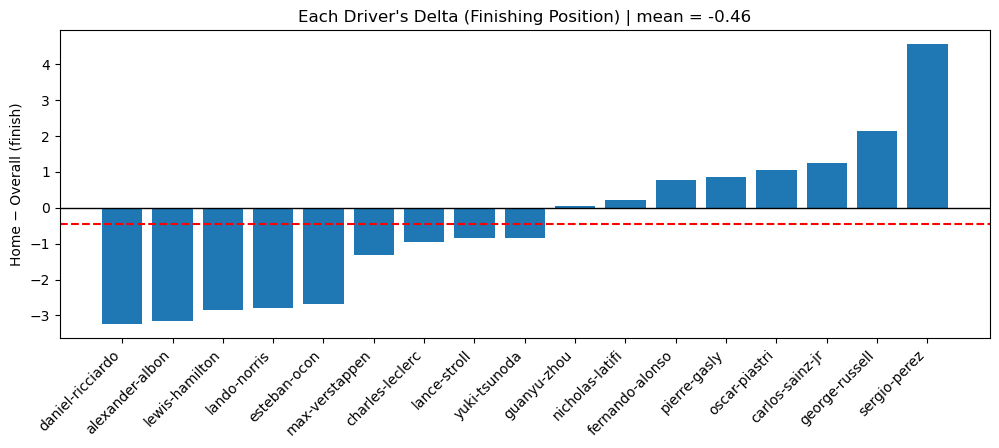

In [1036]:
# BAR: per driver (finish & points) + baseline
order = compare_df.sort_values("delta_finish")["driverId"].tolist()

# Home Finishing Position vs Overall Finishing Position
fig = plt.figure(figsize=(12,4))
plt.bar(range(len(order)), compare_df.set_index("driverId").loc[order, "delta_finish"].values)
plt.axhline(0, color="black", linewidth=1)
plt.axhline(compare_df["delta_finish"].mean(), color="red", linestyle="--")
plt.xticks(range(len(order)), order, rotation=45, ha="right")
plt.ylabel("Home − Overall (finish)")
plt.title(f"Each Driver's Delta (Finishing Position) | mean = {compare_df['delta_finish'].mean():.2f}")
save_chart(fig, "home_adv_by_position", fmt="png", dpi=250)

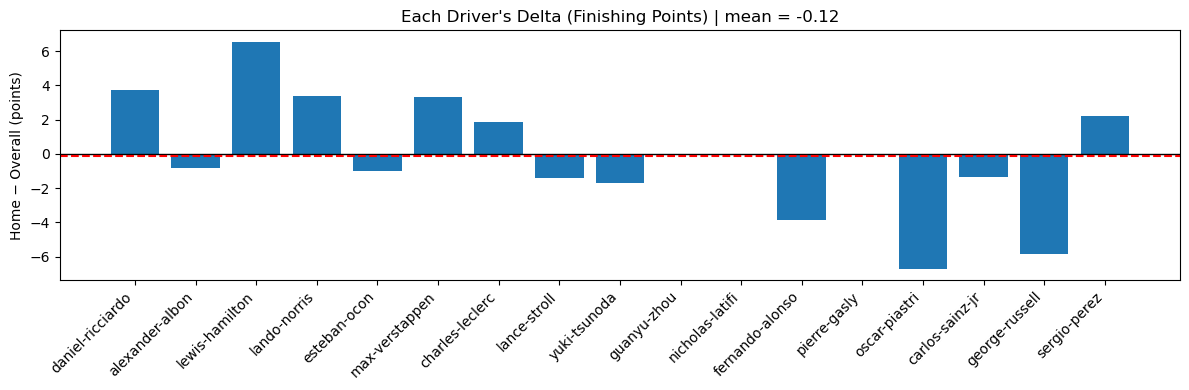

In [1040]:
# Home Finishing Points vs Overall Finishing Points
plt.figure(figsize=(12,4))
fig = plt.bar(range(len(order)), compare_df.set_index("driverId").loc[order, "delta_points"].values)
plt.axhline(0, color="black", linewidth=1)
plt.axhline(compare_df["delta_points"].mean(), color="red", linestyle="--")
plt.xticks(range(len(order)), order, rotation=45, ha="right")
plt.ylabel("Home − Overall (points)")
plt.title(f"Each Driver's Delta (Finishing Points) | mean = {compare_df['delta_points'].mean():.2f}")
plt.tight_layout()
plt.show()

# ML Laptime Predictor (Regression Model)

**GOAL:** Predict per-lap times in F1 races using machine learning

**APPLICATIONS:** 1) Estimate driver pace, 2) analyze driver pace improvement, and 3) (to a lesser extent) estimate tyre degradation

**TARGET VARIABLE:** lap time (seconds, log-transformed for stability)

**DATA:** laps joined with races, drivers, constructors, tyre/stint info, plus rolling pace features

**MODEL:** Gradient Boosting Regressor

**VALIDATION:** grouped cross-validation by raceId to avoid leakage across races

**METRICS:** MAE and RMSE (reported overall and per circuit)

In [564]:
df_guide

,name,rows,cols,sample_cols
0,seasons-tyre-manufacturers,159,12,"[year, tyreManufacturerId, bestStartingGridPos..."
1,grands-prix,53,7,"[id, name, fullName, shortName, abbreviation]"
2,races-pit-stops,21787,15,"[raceId, year, round, positionDisplayOrder, po..."
3,races-starting-grid-positions,25328,17,"[raceId, year, round, positionDisplayOrder, po..."
4,seasons-constructors,1068,16,"[year, constructorId, positionNumber, position..."
5,chassis,1138,4,"[id, constructorId, name, fullName]"
6,races-warming-up-results,7683,18,"[raceId, year, round, positionDisplayOrder, po..."
7,seasons-entrants-tyre-manufacturers,1944,5,"[year, entrantId, constructorId, engineManufac..."
8,races-sprint-race-results,420,34,"[raceId, year, round, positionDisplayOrder, po..."
9,races-qualifying-2-results,7541,24,"[raceId, year, round, positionDisplayOrder, po..."


In [904]:
qualifying_results = raw_dfs["races-qualifying-results"]
qualifying_results_df = filter_recent_era(qualifying_results)
print(qualifying_results_df.columns)
qualifying_results_df.head(1)

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'time', 'timeMillis',
       'q1', 'q1Millis', 'q2', 'q2Millis', 'q3', 'q3Millis', 'gap',
       'gapMillis', 'interval', 'intervalMillis', 'laps'],
      dtype='object')


,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps
24878,1058,2022,1,1,1.0,1,16,charles-leclerc,ferrari,ferrari,...,91471.0,1:30.932,90932.0,1:30.558,90558.0,NaN,NaN,NaN,NaN,15.0


In [527]:
print(races_df.shape)
races_df.head(3)

(92, 42)


,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
1057,1058,2022,1,2022-03-20,NaN,bahrain,Formula 1 Gulf Air Bahrain Grand Prix 2022,KNOCKOUT,NaN,bahrain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1058,1059,2022,2,2022-03-27,NaN,saudi-arabia,Formula 1 stc Saudi Arabian Grand Prix 2022,KNOCKOUT,NaN,jeddah,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1059,1060,2022,3,2022-04-10,NaN,australia,Formula 1 Heineken Australian Grand Prix 2022,KNOCKOUT,NaN,melbourne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


print(drivers_df.shape)
drivers_df.head(3)

In [530]:
print(constructors_df.shape)
constructors_df.head(3)

(185, 19)


,id,name,fullName,countryId,bestChampionshipPosition,bestStartingGridPosition,bestRaceResult,totalChampionshipWins,totalRaceEntries,totalRaceStarts,totalRaceWins,total1And2Finishes,totalRaceLaps,totalPodiums,totalPodiumRaces,totalPoints,totalChampionshipPoints,totalPolePositions,totalFastestLaps
0,adams,Adams,Adams,united-states-of-america,NaN,17.0,27.0,0,1,1,0,0,108,0,0,0.0,0.0,0,0
1,afm,AFM,Alex von Falkenhausen Motorenbau,germany,NaN,9.0,9.0,0,4,4,0,0,98,0,0,0.0,0.0,0,0
2,ags,AGS,Automobiles Gonfaronnaises Sportives,france,11.0,10.0,6.0,0,80,48,0,0,2031,0,0,2.0,2.0,0,0


## Building the Regression Model:

In [1044]:
print(qr_all_df.shape, qr_all_df.columns)
qr_all_df

(86207, 21) Index(['year', 'round', 'session_type', 'event_name', 'session_name', 'driver',
       'driver_number', 'team', 'lap', 'lap_time_s', 's1_s', 's2_s', 's3_s',
       'stint', 'compound', 'tyre_life', 'is_pit_out', 'is_pit_in',
       'is_accurate', 'condition', 'lap_z'],
      dtype='object')


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate,condition,lap_z
0,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2,91.471001,...,39.067001,23.037001,1,SOFT,2.0,<NA>,<NA>,1,Dry,-0.303749
1,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,5,91.356003,...,39.064999,22.878,2,SOFT,5.0,<NA>,<NA>,1,Dry,-0.314984
2,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,8,90.931999,...,38.849998,22.726999,3,SOFT,2.0,<NA>,<NA>,1,Dry,-0.35641
3,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,11,90.731003,...,38.825001,22.707001,4,SOFT,2.0,<NA>,<NA>,1,Dry,-0.376049
4,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,14,90.557999,...,38.702,22.740999,5,SOFT,2.0,<NA>,<NA>,1,Dry,-0.392951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86979,2025,14,R,Hungarian Grand Prix,Race,BEA,87,Haas F1 Team,43,82.496002,...,29.525999,23.156,2,HARD,13.0,<NA>,<NA>,1,Dry,0.15167
86980,2025,14,R,Hungarian Grand Prix,Race,BEA,87,Haas F1 Team,44,82.527,...,29.516001,23.336,2,HARD,14.0,<NA>,<NA>,1,Dry,0.176722
86981,2025,14,R,Hungarian Grand Prix,Race,BEA,87,Haas F1 Team,45,82.529999,...,29.507,23.297001,2,HARD,15.0,<NA>,<NA>,1,Dry,0.179146
86982,2025,14,R,Hungarian Grand Prix,Race,BEA,87,Haas F1 Team,46,84.014,...,30.343,23.481001,2,HARD,16.0,<NA>,<NA>,1,Dry,1.378395


In [538]:
# dropping laps that aren't representative (anything w missing pit/tire data)
m = (qr_all_df["is_pit_out"].fillna(False)==False) & (qr_all_df["is_pit_in"].fillna(False)==False)
qr_all_df = qr_all_df[m]
qr_all_df = qr_all_df.dropna(subset=["compound"])

In [539]:
target = "lap_time_s"
cat_feats = ["driver","team","event_name","session_type","compound"]
num_feats = ["stint","tyre_life","lap","round","year"]
features = cat_feats + num_feats

lr_model_df = qr_all_df[features + [target]].copy()
lr_model_df.shape, lr_model_df[features].dtypes

((86207, 11),
 driver           object
 team             object
 event_name       object
 session_type     object
 compound         object
 stint           float64
 tyre_life       float64
 lap             float64
 round             int64
 year              int64
 dtype: object)

In [729]:
y = lr_model_df["lap_time_s"].values
overall_var = np.var(y, ddof=0)
num_feats = ["stint","tyre_life","lap","round","year"]
cat_feats = ["driver","team","event_name","session_type","compound"]

In [731]:
# numeric: |Spearman|
def spearman_abs(x, y):
    rx = pd.Series(x).rank(method="average").values
    ry = pd.Series(y).rank(method="average").values
    return abs(np.corrcoef(rx, ry)[0,1])
num_scores = {f: spearman_abs(lr_model_df[f].values, y) for f in num_feats}

In [733]:
# categorical: eta-squared
def eta_squared_cat(s, y, overall_var):
    g = pd.DataFrame({"k": s, "y": y}).dropna(subset=["k"])
    means = g.groupby("k")["y"].mean().values
    counts = g.groupby("k")["y"].size().values
    grand = g["y"].mean()
    between = np.sum(counts * (means - grand)**2)
    return float(between / (len(g)*overall_var)) if overall_var>0 else 0.0

In [735]:
cat_scores = {f: eta_squared_cat(lr_model_df[f], y, overall_var) for f in cat_feats}
scores = {**num_scores, **cat_scores}
ranked = pd.DataFrame({"feature": list(scores.keys()), "importance": list(scores.values())}) \
           .sort_values("importance", ascending=False)

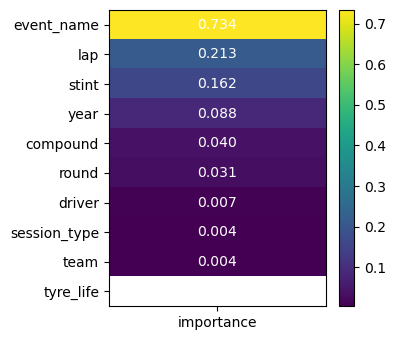

In [739]:
# HEATMAP: Spearman-rated feature importance
vals = ranked[["importance"]].values
labels = ranked["feature"].tolist()
fig, ax = plt.subplots(figsize=(4, max(3, 0.35*len(labels))))
im = ax.imshow(vals, aspect="auto", cmap="viridis")
ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)
ax.set_xticks([0]); ax.set_xticklabels(["importance"])
for i, v in enumerate(vals.flatten()):
    ax.text(0, i, f"{v:.3f}", ha="center", va="center", color="w")
plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()

In [741]:
df = lr_model_df.dropna(subset=["lap_time_s"]).copy()
X = pd.get_dummies(df.drop(columns=["lap_time_s"]), drop_first=True)
y = df["lap_time_s"].values
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X, y)
imp = pd.Series(rf.feature_importances_, index=X.columns)
# aggregate dummy columns back to original feature groups
agg = {}
for col, val in imp.items():
    root = col.split("_")[0]  # crude but works if no underscores in feature names
    agg[root] = agg.get(root, 0) + val
ranked1 = pd.DataFrame({"feature": agg.keys(), "importance": agg.values()}) \
           .sort_values("importance", ascending=False)

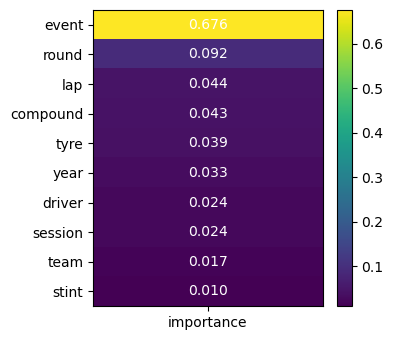

In [749]:
vals = ranked1[["importance"]].values
labels = ranked1["feature"].tolist()
fig, ax = plt.subplots(figsize=(4, max(3, 0.35*len(labels))))
im = ax.imshow(vals, aspect="auto", cmap="viridis")
ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)
ax.set_xticks([0]); ax.set_xticklabels(["importance"])
for i, v in enumerate(vals.flatten()):
    ax.text(0, i, f"{v:.3f}", ha="center", va="center", color="w")
plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()

In [751]:
df = lr_model_df.dropna(subset=["lap_time_s"]).copy()

train = df[df["year"] <= 2023]
test  = df[df["year"] >= 2024]

y_tr = train["lap_time_s"].to_numpy(dtype=float)
y_te = test["lap_time_s"].to_numpy(dtype=float)

X_tr = pd.get_dummies(train.drop(columns=["lap_time_s"]), drop_first=True)
X_te = pd.get_dummies(test.drop(columns=["lap_time_s"]), drop_first=True).reindex(columns=X_tr.columns, fill_value=0)

Xb_tr = np.c_[np.ones(len(X_tr)), X_tr.to_numpy(dtype=float)]
Xb_te = np.c_[np.ones(len(X_te)), X_te.to_numpy(dtype=float)]

# drop any non-finite rows (defensive)
m_tr = np.isfinite(Xb_tr).all(axis=1) & np.isfinite(y_tr)
m_te = np.isfinite(Xb_te).all(axis=1) & np.isfinite(y_te)
Xb_tr, y_tr = Xb_tr[m_tr], y_tr[m_tr]
Xb_te, y_te = Xb_te[m_te], y_te[m_te]

In [753]:
# Ridge closed-form to avoid SVD issues
alpha = 1.0
XtX = Xb_tr.T @ Xb_tr
Xty = Xb_tr.T @ y_tr
beta = np.linalg.solve(XtX + alpha * np.eye(XtX.shape[0]), Xty)

pred_tr = Xb_tr @ beta
pred_te = Xb_te @ beta

print("Train MAE:", round(mean_absolute_error(y_tr, pred_tr), 3))
print("Train RMSE:", round(mean_squared_error(y_tr, pred_tr, squared=False), 3))
print("Train R²:", round(r2_score(y_tr, pred_tr), 4))
print("Test  MAE:", round(mean_absolute_error(y_te, pred_te), 3))
print("Test  RMSE:", round(mean_squared_error(y_te, pred_te, squared=False), 3))
print("Test  R²:", round(r2_score(y_te, pred_te), 4))

coef = pd.Series(beta[1:], index=X_tr.columns).sort_values(key=np.abs, ascending=False)
coef.head(20)

Train MAE: 2.848
Train RMSE: 5.81
Train R²: 0.7879
Test  MAE: 3.698
Test  RMSE: 5.439
Test  R²: 0.7686


event_name_Belgian Grand Prix           23.046526
event_name_Azerbaijan Grand Prix        19.958587
compound_WET                            17.096641
event_name_Austrian Grand Prix         -16.916300
event_name_Singapore Grand Prix         14.829945
event_name_São Paulo Grand Prix        -13.641367
event_name_Dutch Grand Prix            -13.104285
compound_INTERMEDIATE                   12.599375
event_name_United States Grand Prix     12.225570
event_name_Canadian Grand Prix         -10.905915
event_name_Las Vegas Grand Prix         10.065245
event_name_Bahrain Grand Prix            9.466105
event_name_French Grand Prix             9.384401
event_name_Japanese Grand Prix           7.599422
event_name_Monaco Grand Prix            -7.547409
event_name_Saudi Arabian Grand Prix      7.441658
event_name_Emilia Romagna Grand Prix    -6.691305
event_name_Mexico City Grand Prix       -6.246148
event_name_Miami Grand Prix              5.391756
event_name_Spanish Grand Prix           -5.212961


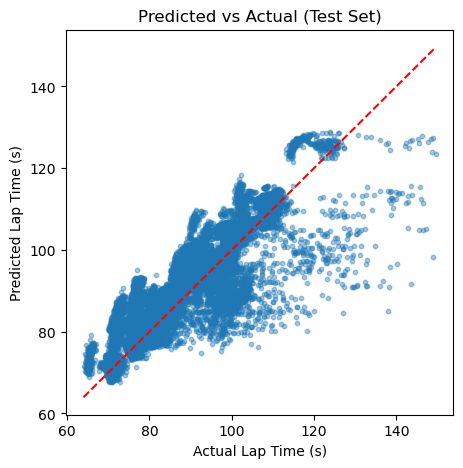

In [755]:
# SCT w/ REG.LINE: Predicted vs Actual
plt.figure(figsize=(5,5))
plt.scatter(y_te, pred_te, alpha=0.4, s=10)
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--')
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Predicted vs Actual (Test Set)")
plt.show()

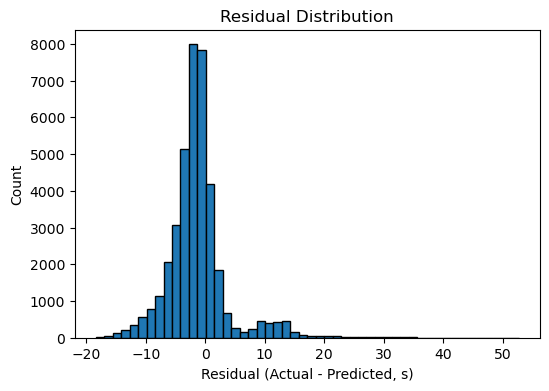

In [756]:
# HIST: Residuals histogram
residuals = y_te - pred_te
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor="k")
plt.xlabel("Residual (Actual - Predicted, s)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()

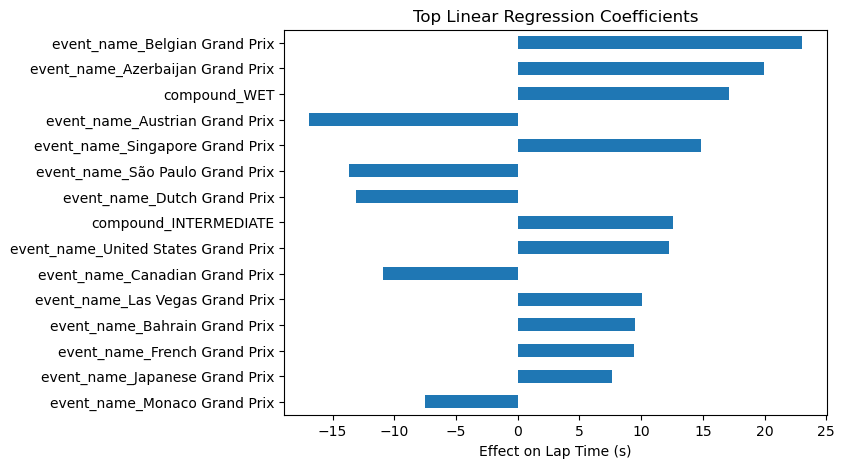

In [758]:
# HBAR: Top coefficients
top_coef = coef.head(15)
plt.figure(figsize=(7,5))
top_coef[::-1].plot(kind="barh")
plt.title("Top Linear Regression Coefficients")
plt.xlabel("Effect on Lap Time (s)")
plt.show()

**Predicted vs Actual Scatter:**

- most laps sit right along the red line => the model’s catching the core lap times nicely

- I can see the track “bands” show up clearly, each circuit grouping its laps

- the misses are mostly on the long, slow laps — feels like pit-outs or aborted laps slipped through

**Residual Distribution:**

- centered close to 0 => no crazy bias, but a little negative skew, so it’s nudging lap times a bit too high overall

- bulk of errors stay within ±10s, which is honestly solid for this data

- the long tails (20–50s) are rare outliers => yeah, those are the messy laps the model can’t explain

**Top Linear Regression Coefficients:**

- Belgian and Azerbaijan GPs are huge positives => makes sense, those are long tracks

- wet tyres pop up with +17s, intermediates +12s => exactly what I’d expect

- Austrian, São Paulo, Dutch GPs come in strongly negative => short, fast circuits

- everything else is smaller, reinforcing that track and tyre compound dominate, while stint/driver/team are background noise

In [923]:
def predict_lap_lnr(beta, base_X, driver, team, event_name, session_type, compound, stint, tyre_life, lap, year, round_):
    '''Predict lap time using the fitted Linear Regression beta coefficients.
    Inputs:
        driver        : e.g. "VER"
        team          : e.g. "Red Bull Racing"
        event_name    : e.g. "Bahrain Grand Prix"
        session_type  : e.g. "Qualifying"
        compound      : e.g. "SOFT"
        stint, tyre_life, lap, year, round_ : int'''
    df = pd.DataFrame([{"driver": driver,
                        "team": team,
                        "event_name": event_name,
                        "session_type": session_type,
                        "compound": compound,
                        "stint": stint,
                        "tyre_life": tyre_life,
                        "lap": lap,
                        "year": year,
                        "round": round_}])

    X_new = pd.get_dummies(df, drop_first=True).reindex(columns=base_X.columns, fill_value=0)
    Xb_new = np.c_[np.ones(len(X_new)), X_new.to_numpy(dtype=float)]
    pred = Xb_new @ beta
    print(f"LNR Prediction: {driver} {event_name} {year} ({session_type}, {compound}, Lap {lap}):", round(float(pred[0]), 4), "seconds")
    return round(float(pred[0]), 4)

In [547]:
lnr_pred = predict_lap_lnr(
    beta, X_tr,
    driver="ALB",
    team="Williams",
    event_name="Belgian Grand Prix",
    session_type="Qualifying",
    compound="SOFT",
    stint=1,
    tyre_life=3,
    lap=5,
    year=2025,
    round_=13)

LNR Prediction: ALB Belgian Grand Prix 2025 (Qualifying, SOFT, Lap 5): 91.0776 seconds


### RF Model: 

**- laptimes contain non-linear patterns, RF might be better**

In [922]:
# RF Model
df = lr_model_df.dropna(subset=["lap_time_s"]).copy()
train = df[df["year"] <= 2023]
test  = df[df["year"] >= 2024]

y_tr = train["lap_time_s"].to_numpy(dtype=float)
y_te = test["lap_time_s"].to_numpy(dtype=float)

X_tr = pd.get_dummies(train.drop(columns=["lap_time_s"]), drop_first=True)
X_te = pd.get_dummies(test.drop(columns=["lap_time_s"]), drop_first=True).reindex(columns=X_tr.columns, fill_value=0)

# model
rf = RandomForestRegressor(n_estimators=600,
                           max_depth=None,          
                           min_samples_leaf=5,     
                           n_jobs=-1,random_state=42)
rf.fit(X_tr, y_tr)

# predictions & metrics
pred_tr = rf.predict(X_tr)
pred_te = rf.predict(X_te)
print("RF Train  MAE:", round(mean_absolute_error(y_tr, pred_tr), 3))
print("RF Train  RMSE:", round(mean_squared_error(y_tr, pred_tr, squared=False), 3))
print("RF Train  R²:", round(r2_score(y_tr, pred_tr), 4))
print("RF Test   MAE:", round(mean_absolute_error(y_te, pred_te), 3))
print("RF Test   RMSE:", round(mean_squared_error(y_te, pred_te, squared=False), 3))
print("RF Test   R²:", round(r2_score(y_te, pred_te), 4))

RF Train  MAE: 1.081
RF Train  RMSE: 3.391
RF Train  R²: 0.9278
RF Test   MAE: 4.18
RF Test   RMSE: 6.59
RF Test   R²: 0.6605


In [766]:
# aggregate importances back to original feature names
imp = pd.Series(rf.feature_importances_, index=X_tr.columns)

In [769]:
def root_name(col):
    # for one-hot columns like 'event_name_Bahrain Grand Prix' -> 'event_name'
    return col.split("_", 1)[0] if "_" in col else col

agg = {}
for col, val in imp.items():
    agg[root_name(col)] = agg.get(root_name(col), 0.0) + float(val)

ranked = pd.DataFrame({"feature": list(agg.keys()), "importance": list(agg.values())}) \
           .sort_values("importance", ascending=False)
display(ranked)

,feature,importance
7,event,0.719542
3,round,0.083964
1,tyre,0.050064
9,compound,0.043809
2,lap,0.038119
8,session,0.025958
4,year,0.020544
6,team,0.007132
0,stint,0.006960
5,driver,0.003906


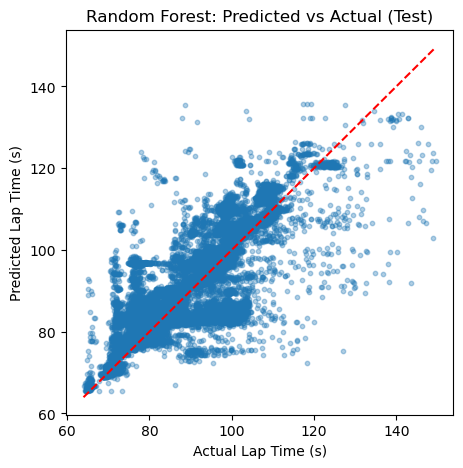

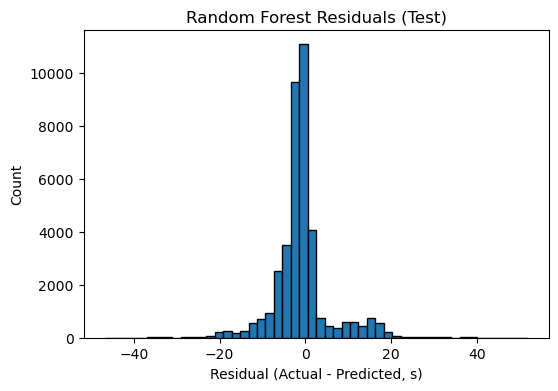

In [771]:
# visuals
plt.figure(figsize=(5,5))
plt.scatter(y_te, pred_te, alpha=0.35, s=10)
mn, mx = float(min(y_te.min(), pred_te.min())), float(max(y_te.max(), pred_te.max()))
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("Actual Lap Time (s)"); plt.ylabel("Predicted Lap Time (s)")
plt.title("Random Forest: Predicted vs Actual (Test)"); plt.show()

residuals = y_te - pred_te
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor="k")
plt.xlabel("Residual (Actual - Predicted, s)"); plt.ylabel("Count")
plt.title("Random Forest Residuals (Test)"); plt.show()

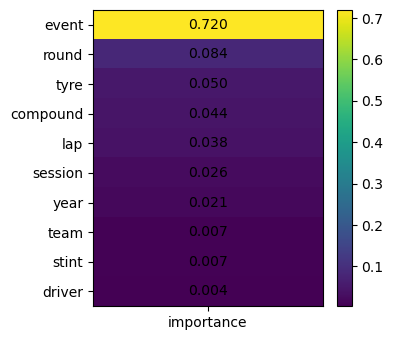

In [773]:
top = ranked.head(12)
vals = top["importance"].values[:, None]
labels = top["feature"].tolist()
fig, ax = plt.subplots(figsize=(4, max(3, 0.35*len(labels))))
im = ax.imshow(vals, aspect="auto")
ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)
ax.set_xticks([0]); ax.set_xticklabels(["importance"])
for i, v in enumerate(vals.flatten()):
    ax.text(0, i, f"{v:.3f}", ha="center", va="center")
plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

In [775]:
def predict_lap_rf(model, base_X, driver, team, event_name, session_type, compound, stint, tyre_life, lap, year, round_):
    '''Predict lap time using a trained RandomForestRegressor.
    Inputs:
      driver        : e.g. "VER"
      team          : e.g. "Red Bull Racing"
      event_name    : e.g. "Bahrain Grand Prix"
      session_type  : e.g. "Qualifying"
      compound      : e.g. "SOFT"
      stint, tyre_life, lap, year, round_ : int '''
    df = pd.DataFrame([{"driver": driver,
                        "team": team,
                        "event_name": event_name,
                        "session_type": session_type,
                        "compound": compound,
                        "stint": stint,
                        "tyre_life": tyre_life,
                        "lap": lap,
                        "year": year,
                        "round": round_}])
    X_new = pd.get_dummies(df, drop_first=True).reindex(columns=base_X.columns, fill_value=0)
    pred = model.predict(X_new)[0]
    pred_val = round(float(pred), 4)
    print(f"RF Prediction: {driver} {event_name} {year} ({session_type}, {compound}, Lap {lap}):", pred_val, "seconds")
    return pred_val

In [777]:
rf_pred = predict_lap_rf(
    rf, X_tr,
    driver="ALB",
    team="Williams",
    event_name="Belgian Grand Prix",
    session_type="Qualifying",
    compound="SOFT",
    stint=1,
    tyre_life=3,
    lap=5,
    year=2025,
    round_=13)

RF Prediction: ALB Belgian Grand Prix 2025 (Qualifying, SOFT, Lap 5): 103.7472 seconds


## Moving onto Next Model:

#### Currently:
- Ridge is solid (R² ≈ 0.79, Test MAE ≈ 3.7s)  
- RF less bias but overfits (Train MAE ≈ 1.1s vs Test MAE ≈ 4.2s)  
- General trends for every circuit seems ot be capture well
- Residuals show long-tail errors–– outliers being missed/at least not taken w as much weight (slow laps, pit-outs, safety car laps)  

#### Weaknesses:
- **Feature dominance**  
  - Circuit/event name explains most variance => model leans heavily on track identity  
  - Other factors (stint, tyre life, driver/team) contribute less, treated as noise  
- **Data leakage/noise**  
  - Long, abnormal laps (pit-outs, aborted laps) slip through => skew error distribution  
  - Outliers (20–50s residuals) hurt generalization  
- **Possible limitations**  
  - Linear regression struggles with non-linear tyre degradation effects  
  - Random Forest improves accuracy but may overfit to specific circuits/events  
- **Context gaps**  
  - No weather/track temp data  
  - No sector-level dynamics beyond aggregated lap time  
  - No traffic/gap effects included  

#### Path Forward:
- Clean outlier laps better (pit-outs, safety laps, aborted runs)  
- More context features (weather, track length, sector splits, track temp, altitude)  
- Try non-linear models, might capture non-linear tyre/stint effects better

In [863]:
ID_KEYS = ["raceId","driverNumber","lap"]
MIN_COLS = ["raceId","driverNumber","lap","lap_time_s"]
SECTOR_COLS = [c for c in ["s1","s2","s3"] if c in globals().get("laps_df",pd.DataFrame()).columns]

In [865]:
def _require_cols(df,name,cols):
  missing=[c for c in cols if c not in df.columns]
  if missing: raise ValueError(f"{name} missing: {missing}")

In [871]:
laps_df.head(1)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,tyre_life,pit_in_flag_x,stint,deg_slope_5,deg_accel_3,tyre_life_sq,air_delta_3,in_train_flag,sc_flag,pit_in_flag_y
0,1058,2022,1,2,2,2,1,max-verstappen,red-bull,rbpt,...,0,0,1,NaN,NaN,0.0,NaN,0,0,NaN


In [873]:
pit_stops_df.head(1)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,stop,lap,time,timeMillis
18755,1058,2022,1,1,1,1,44,lewis-hamilton,mercedes,mercedes,pirelli,1,11,25.201,25201.0


In [879]:
qr_all_df.head(1)

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate,condition,lap_z
0,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2,91.471001,...,39.067001,23.037001,1,SOFT,2.0,<NA>,<NA>,1,Dry,-0.303749


In [908]:
circuits_df.head(1)

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.78,16,11


In [906]:
qualifying_results_df.head(1)

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,q1Millis,q2,q2Millis,q3,q3Millis,gap,gapMillis,interval,intervalMillis,laps
24878,1058,2022,1,1,1.0,1,16,charles-leclerc,ferrari,ferrari,...,91471.0,1:30.932,90932.0,1:30.558,90558.0,NaN,NaN,NaN,NaN,15.0


In [910]:
# Merging qualifying_results_df w/ qr_all_df, so qualifying laps are tied to results => easier to tell bad laps
# filter to qualifying laps
qlaps = qr_all_df.query("session_type=='Q'").copy()
qlaps["driver_number"] = qlaps["driver_number"].astype(int)
qlaps["round"] = qlaps["round"].astype(int)
qlaps["year"] = qlaps["year"].astype(int)
# prep qualifying results
qres = qualifying_results_df.copy()
qres["driverNumber"] = qres["driverNumber"].astype(int)
qres["round"] = qres["round"].astype(int)
qres["year"] = qres["year"].astype(int)

keep_res_cols = ["raceId","year","round","driverNumber","driverId","constructorId",
                 "q1Millis","q2Millis","q3Millis","timeMillis","positionNumber","laps"]
qres = qres[[c for c in keep_res_cols if c in qres.columns]]

In [914]:
qr_df = qlaps.merge(qres, left_on=["year","round","driver_number"],
                    right_on=["year","round","driverNumber"], how="left")
qr_df

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,raceId,driverNumber,driverId,constructorId,q1Millis,q2Millis,q3Millis,timeMillis,positionNumber,laps
0,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2,91.471001,...,1058,16,charles-leclerc,ferrari,91471.0,90932.0,90558.0,NaN,1.0,15.0
1,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,5,91.356003,...,1058,16,charles-leclerc,ferrari,91471.0,90932.0,90558.0,NaN,1.0,15.0
2,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,8,90.931999,...,1058,16,charles-leclerc,ferrari,91471.0,90932.0,90558.0,NaN,1.0,15.0
3,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,11,90.731003,...,1058,16,charles-leclerc,ferrari,91471.0,90932.0,90558.0,NaN,1.0,15.0
4,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,14,90.557999,...,1058,16,charles-leclerc,ferrari,91471.0,90932.0,90558.0,NaN,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10993,2025,14,Q,Hungarian Grand Prix,Qualifying,HUL,27,Kick Sauber,2,76.266998,...,1139,27,nico-hulkenberg,kick-sauber,76081.0,NaN,NaN,NaN,19.0,6.0
10994,2025,14,Q,Hungarian Grand Prix,Qualifying,HUL,27,Kick Sauber,5,76.081001,...,1139,27,nico-hulkenberg,kick-sauber,76081.0,NaN,NaN,NaN,19.0,6.0
10995,2025,14,Q,Hungarian Grand Prix,Qualifying,ALB,23,Williams,2,77.441002,...,1139,23,alexander-albon,williams,76223.0,NaN,NaN,NaN,20.0,9.0
10996,2025,14,Q,Hungarian Grand Prix,Qualifying,ALB,23,Williams,5,76.447998,...,1139,23,alexander-albon,williams,76223.0,NaN,NaN,NaN,20.0,9.0


In [939]:
qr_df.dtypes

year                     int64
round                    int64
session_type          category
event_name            category
session_name          category
driver                category
driver_number            int64
team                  category
lap                      Int16
lap_time_s             Float32
s1_s                   Float32
s2_s                   Float32
s3_s                   Float32
stint                    Int16
compound              category
tyre_life              Float32
is_pit_out                Int8
is_pit_in                 Int8
is_accurate               Int8
condition             category
lap_z                  Float32
raceId                   int64
driverNumber             int64
driverId                object
constructorId           object
q1Millis               float64
q2Millis               float64
q3Millis               float64
timeMillis             float64
positionNumber         float64
laps                   float64
q_best_ms              float64
lap_ms  

In [920]:
for c in ["q1Millis","q2Millis","q3Millis","timeMillis"]:
    if c in qr_df.columns:
        qr_df[c] = pd.to_numeric(qr_df[c], errors="coerce")
qr_df["q_best_ms"] = qr_df[["q1Millis","q2Millis","q3Millis"]].min(axis=1, skipna=True)
qr_df["lap_ms"] = qr_df["lap_time_s"]*1000
qr_df["lap_minus_qbest_ms"] = qr_df["lap_ms"] - qr_df["q_best_ms"]
print(qr_df.shape, qr_df.columns)
qr_df.head(1)

(10998, 34) Index(['year', 'round', 'session_type', 'event_name', 'session_name', 'driver',
       'driver_number', 'team', 'lap', 'lap_time_s', 's1_s', 's2_s', 's3_s',
       'stint', 'compound', 'tyre_life', 'is_pit_out', 'is_pit_in',
       'is_accurate', 'condition', 'lap_z', 'raceId', 'driverNumber',
       'driverId', 'constructorId', 'q1Millis', 'q2Millis', 'q3Millis',
       'timeMillis', 'positionNumber', 'laps', 'q_best_ms', 'lap_ms',
       'lap_minus_qbest_ms'],
      dtype='object')


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,constructorId,q1Millis,q2Millis,q3Millis,timeMillis,positionNumber,laps,q_best_ms,lap_ms,lap_minus_qbest_ms
0,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2,91.471001,...,ferrari,91471.0,90932.0,90558.0,NaN,1.0,15.0,90558.0,91471.0,913.0


In [943]:
# Filter bad laps, model's more accurate with less noise, gonna try to predict their "best behavior" accurately first. 
# Bad laps perhaps for another day
qr_df = qr_df.copy()
qr_df["is_pit_out"] = qr_df["is_pit_out"].fillna(0).astype(bool)
qr_df["is_pit_in"] = qr_df["is_pit_in"].fillna(0).astype(bool)
qr_df["is_accurate"] = qr_df["is_accurate"].fillna(0).astype(bool)
mask_qbest = qr_df["q_best_ms"].notna()
mask_gap = (qr_df["lap_minus_qbest_ms"]>=0) & (qr_df["lap_minus_qbest_ms"]<=2000)
qr_df = qr_df[qr_df["is_accurate"] & ~qr_df["is_pit_out"] & ~qr_df["is_pit_in"] & mask_qbest & mask_gap]

In [945]:
# New features: sector ratios/laptimes
# More specific clues for model to learn
qr_df["s1_ratio"] = qr_df["s1_s"]/qr_df["lap_time_s"]
qr_df["s2_ratio"] = qr_df["s2_s"]/qr_df["lap_time_s"]
qr_df["s3_ratio"] = qr_df["s3_s"]/qr_df["lap_time_s"]

In [947]:
# RF v2
X_num = ["s1_s","s2_s","s3_s","s1_ratio","s2_ratio","s3_ratio",
         "stint","tyre_life","lap","lap_minus_qbest_ms"]

X_cat = ["constructorId","driverId","event_name","compound"]

y = (qr_df["lap_time_s"]*1000).astype(float)
groups = qr_df["raceId"] 

In [951]:
pre = ColumnTransformer([("num","passthrough",X_num),
                         ("cat",OneHotEncoder(handle_unknown="ignore"),X_cat)])
pipe = Pipeline([("pre",pre),("reg",Ridge(alpha=1.0))])

cv = GroupKFold(n_splits=5)
mae_ms = -cross_val_score(pipe, qr_df[X_num+X_cat], y,
                          scoring="neg_mean_absolute_error",
                          cv=cv, groups=groups)
print("MAE(ms):", mae_ms.mean(), "±", mae_ms.std())

MAE(ms): 12.03015715367997 ± 3.493372209077988


In [953]:
gkf = GroupKFold(n_splits=5)
y_true_parts, y_pred_parts, idx_parts = [], [], []

for tr, te in gkf.split(qr_df[X_num+X_cat], y, groups):
  pipe.fit(qr_df.iloc[tr][X_num+X_cat], y.iloc[tr])
  y_true_parts.append(y.iloc[te].values)
  y_pred_parts.append(pipe.predict(qr_df.iloc[te][X_num+X_cat]))
  idx_parts.append(te)

y_true_oof = np.concatenate(y_true_parts)
y_pred_oof = np.concatenate(y_pred_parts)
idx_oof = np.concatenate(idx_parts)

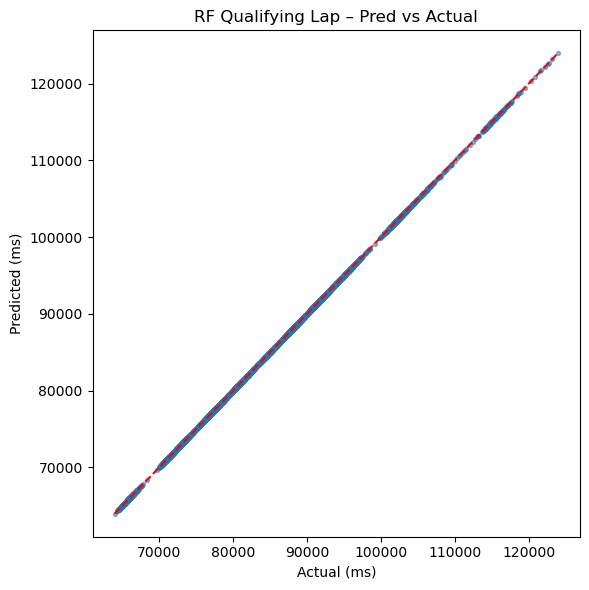

In [967]:
# SCT: Pred. v Act.
plt.figure(figsize=(6,6))
plt.scatter(y_true_oof, y_pred_oof, s=8, alpha=0.5)
lims = [min(y_true_oof.min(), y_pred_oof.min()), max(y_true_oof.max(), y_pred_oof.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual (ms)")
plt.ylabel("Predicted (ms)")
plt.title("RF Qualifying Lap – Pred vs Actual")
plt.tight_layout(); plt.show()

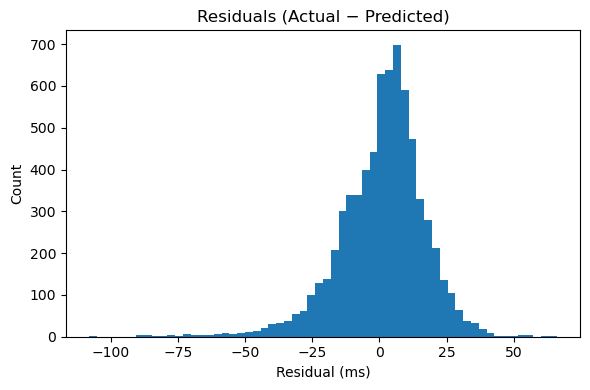

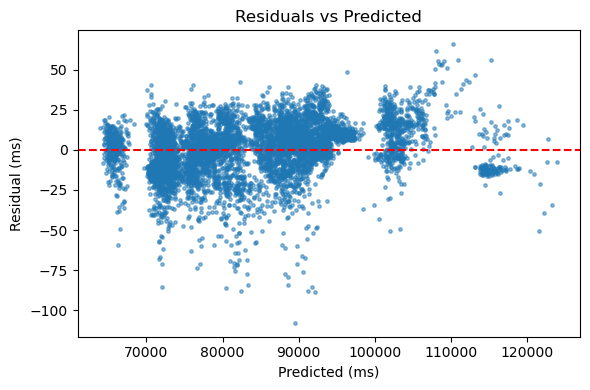

In [971]:
# Residuals
res = y_true_oof - y_pred_oof

plt.figure(figsize=(6,4))
plt.hist(res, bins=60)
plt.xlabel("Residual (ms)")
plt.ylabel("Count")
plt.title("Residuals (Actual − Predicted)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred_oof, res, s=6, alpha=0.5)
plt.axhline(0, color = 'red', linestyle = '--')
plt.xlabel("Predicted (ms)")
plt.ylabel("Residual (ms)")
plt.title("Residuals vs Predicted")
plt.tight_layout(); plt.show()

# ML Pit Stop Strategist (Classification/Simulation Model)

**GOAL:** Predict optimal pit stop windows and tyre choices during F1 races

**APPLICATIONS:** 1) Simulate alternate race strategies, 2) estimate under/overcut potential, and 3) evaluate tyre degradation vs pit cost tradeoffs

**TARGET VARIABLE:** binary/ordinal indicator of whether a lap is an optimal pit lap (or multi-class for tyre choice)

**DATA:** lap-by-lap times joined with stints, tyre compound, tyre life, pit stop history, weather (if available), gaps to cars ahead/behind, safety car/VSC flags, and circuit characteristics

**MODEL:** Gradient Boosting Classifier (for pit decision) + simulation layer to accumulate race time under different strategy paths

**VALIDATION:** grouped cross-validation by raceId to avoid leakage across races

**METRICS:** accuracy and F1 for pit decision classification; simulated race time delta compared to actual strategies

In [779]:
print(qr_all_df.columns)
qr_all_df.head(3)

Index(['year', 'round', 'session_type', 'event_name', 'session_name', 'driver',
       'driver_number', 'team', 'lap', 'lap_time_s', 's1_s', 's2_s', 's3_s',
       'stint', 'compound', 'tyre_life', 'is_pit_out', 'is_pit_in',
       'is_accurate', 'condition', 'lap_z'],
      dtype='object')


,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,s2_s,s3_s,stint,compound,tyre_life,is_pit_out,is_pit_in,is_accurate,condition,lap_z
0,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,2.0,91.471,...,39.067,23.037,1.0,SOFT,2.0,<NA>,<NA>,True,Dry,-0.303749
1,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,5.0,91.356,...,39.065,22.878,2.0,SOFT,5.0,<NA>,<NA>,True,Dry,-0.314984
2,2022,1,Q,Bahrain Grand Prix,Qualifying,LEC,16,Ferrari,8.0,90.932,...,38.850,22.727,3.0,SOFT,2.0,<NA>,<NA>,True,Dry,-0.356410


In [781]:
qr_all_df.dtypes

year               int64
round              int64
session_type      object
event_name        object
session_name      object
driver            object
driver_number      int64
team              object
lap              float64
lap_time_s       float64
s1_s             float64
s2_s             float64
s3_s             float64
stint            float64
compound          object
tyre_life        float64
is_pit_out       boolean
is_pit_in        boolean
is_accurate      boolean
condition         object
lap_z            float64
dtype: object

In [783]:
# numeric -> nullable ints / floats
qr_all_df["year"] = pd.to_numeric(qr_all_df["year"], errors="coerce").astype("Int16")
qr_all_df["round"] = pd.to_numeric(qr_all_df["round"], errors="coerce").astype("Int16")
qr_all_df["driver_number"] = pd.to_numeric(qr_all_df["driver_number"], errors="coerce").astype("Int16")
qr_all_df["lap"] = pd.to_numeric(qr_all_df["lap"], errors="coerce").astype("Int16")
qr_all_df["stint"] = pd.to_numeric(qr_all_df["stint"], errors="coerce").astype("Int16")
qr_all_df["tyre_life"] = pd.to_numeric(qr_all_df["tyre_life"], errors="coerce").astype("Float32")

for c in ["lap_time_s","s1_s","s2_s","s3_s","lap_z"]:
    qr_all_df[c] = pd.to_numeric(qr_all_df[c], errors="coerce").astype("Float32")

# booleans -> ints (booleans run into errors)
for c in ["is_pit_out","is_pit_in","is_accurate"]:
    qr_all_df[c] = qr_all_df[c].astype("Int8")

# text -> categories
for c in ["session_type","event_name","session_name","driver","team","compound","condition"]:
    qr_all_df[c] = qr_all_df[c].astype("category")

In [785]:
print(race_results_df.columns)
race_results_df.head(1)

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'sharedCar', 'laps',
       'time', 'timeMillis', 'timePenalty', 'timePenaltyMillis', 'gap',
       'gapMillis', 'gapLaps', 'interval', 'intervalMillis', 'reasonRetired',
       'points', 'polePosition', 'qualificationPositionNumber',
       'qualificationPositionText', 'gridPositionNumber', 'gridPositionText',
       'positionsGained', 'pitStops', 'fastestLap', 'driverOfTheDay',
       'grandSlam', 'circuitId', 'delta'],
      dtype='object')


,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam,circuitId,delta
25452,1058,2022,1,1,1,1,16,charles-leclerc,ferrari,ferrari,...,1,1.0,1,0.0,3.0,True,True,False,bahrain,0.0


In [787]:
print(circuits_df.columns)
circuits_df.head(1)

Index(['id', 'name', 'fullName', 'previousNames', 'type', 'direction',
       'placeName', 'countryId', 'latitude', 'longitude', 'length', 'turns',
       'totalRacesHeld'],
      dtype='object')


,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.78,16,11


In [789]:
print(pit_stops_df.columns)
pit_stops_df.head(1)

Index(['raceId', 'year', 'round', 'positionDisplayOrder', 'positionNumber',
       'positionText', 'driverNumber', 'driverId', 'constructorId',
       'engineManufacturerId', 'tyreManufacturerId', 'stop', 'lap', 'time',
       'timeMillis'],
      dtype='object')


,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,stop,lap,time,timeMillis
18755,1058,2022,1,1,1,1,44,lewis-hamilton,mercedes,mercedes,pirelli,1,11,25.201,25201.0


In [791]:
# setting up df's for this model
race_laps_df = qr_all_df.query("session_type=='R'").copy()
race_laps_df["driver_number"] = race_laps_df["driver_number"].astype(int)
race_laps_df["lap"] = race_laps_df["lap"].astype(int)

results_df = race_results_df.copy()
results_df["driverNumber"] = results_df["driverNumber"].astype(int)
results_df = results_df[["raceId","year","round","driverNumber","constructorId","circuitId","laps","timeMillis","positionNumber"]]

race_laps_df = race_laps_df.merge(results_df,
                                  left_on=["year","round","driver_number"],
                                  right_on=["year","round","driverNumber"], how="left")

circuits_slice_df = circuits_df[["id","length","turns","type"]].rename(columns={"id":"circuitId"})
race_laps_df = race_laps_df.merge(circuits_slice_df, on="circuitId", how="left")

In [1228]:
# pits
pits_df = pit_stops_df[["raceId","driverNumber","stop","lap","timeMillis"]].rename(
    columns={"stop":"stop_n","lap":"pit_lap","timeMillis":"pit_time_ms"})
pits_df["driverNumber"] = pits_df["driverNumber"].astype(int)
pits_df["pit_lap"] = pits_df["pit_lap"].astype(int)

pit_flags_df = pits_df.assign(pit_in_flag=1)[["raceId","driverNumber","pit_lap","pit_in_flag","pit_time_ms"]].rename(columns={"pit_lap":"lap"})
race_laps_df = race_laps_df.merge(pit_flags_df, on=["raceId","driverNumber","lap"], how="left")

if "is_pit_in" in race_laps_df.columns:
    race_laps_df["is_pit_in"] = race_laps_df["is_pit_in"].fillna(race_laps_df["pit_in_flag"]).fillna(0).astype(int)
else:
    race_laps_df["is_pit_in"] = race_laps_df["pit_in_flag"].fillna(0).astype(int)
race_laps_df = race_laps_df.drop(columns=["pit_in_flag"])

In [1232]:
# features
race_laps_df = race_laps_df.sort_values(["raceId","driver_number","stint","lap"])
g = race_laps_df.groupby(["raceId","driver_number","stint"])
race_laps_df["roll_mean_3"] = g["lap_time_s"].transform(lambda s: s.rolling(3,min_periods=1).mean())
race_laps_df["roll_std_5"]  = g["lap_time_s"].transform(lambda s: s.rolling(5,min_periods=1).std())
race_laps_df["rolling_min_5"] = g["lap_time_s"].transform(lambda s: s.rolling(5,min_periods=1).min())
race_laps_df["dlap_s"] = race_laps_df["lap_time_s"] - race_laps_df["rolling_min_5"]
race_laps_df["is_wet"] = race_laps_df["compound"].isin(["INTERMEDIATE","WET"]).astype(int)

In [1233]:
# target (avoid boolean dtype issue by merging once with an INT label)
next_pit_df = pits_df.rename(columns={"pit_lap":"lap"})[["raceId","driverNumber","lap"]].copy()
windows_df = pd.concat([next_pit_df.assign(lap=next_pit_df["lap"]+k) for k in (-1,0,1)],ignore_index=True).drop_duplicates()
windows_df["y_is_pit_window"] = 1

In [1230]:
if "y_is_pit_window" in race_laps_df.columns:
    race_laps_df = race_laps_df.drop(columns=["y_is_pit_window"])

race_laps_df = race_laps_df.merge(windows_df, on=["raceId","driverNumber","lap"], how="left")
race_laps_df["y_is_pit_window"] = race_laps_df["y_is_pit_window"].fillna(0).astype(int)

In [796]:
# final modeling df
laps_model_df = race_laps_df.dropna(subset=["raceId","driverNumber"])
laps_model_df.head()

,year,round,session_type,event_name,session_name,driver,driver_number,team,lap,lap_time_s,...,length,turns,type,pit_time_ms,roll_mean_3,roll_std_5,rolling_min_5,dlap_s,is_wet,y_is_pit_window
0,2022,1,R,Bahrain Grand Prix,Race,VER,1,Red Bull Racing,2,97.879997,...,5.412,15.0,RACE,NaN,97.879997,NaN,97.879997,0.0,0,0
1,2022,1,R,Bahrain Grand Prix,Race,VER,1,Red Bull Racing,3,98.357002,...,5.412,15.0,RACE,NaN,98.118500,0.337293,97.879997,0.477005,0,0
2,2022,1,R,Bahrain Grand Prix,Race,VER,1,Red Bull Racing,4,98.566002,...,5.412,15.0,RACE,NaN,98.267667,0.351619,97.879997,0.686005,0,0
3,2022,1,R,Bahrain Grand Prix,Race,VER,1,Red Bull Racing,5,98.876999,...,5.412,15.0,RACE,NaN,98.600001,0.418623,97.879997,0.997002,0,0
4,2022,1,R,Bahrain Grand Prix,Race,VER,1,Red Bull Racing,6,98.940002,...,5.412,15.0,RACE,NaN,98.794334,0.430714,97.879997,1.060005,0,0


In [797]:
use_cols_num = ["lap","stint","tyre_life","lap_time_s","roll_mean_3","roll_std_5","rolling_min_5","dlap_s","is_wet","length","turns","is_pit_in"]
use_cols_cat = ["compound","type"]
X_df = laps_model_df[use_cols_num+use_cols_cat].copy()
y = laps_model_df["y_is_pit_window"].astype(int).values
groups = laps_model_df["raceId"].values

In [798]:
# simple imputes
X_df[use_cols_num] = X_df[use_cols_num].fillna(0)
X_df["type"] = X_df["type"].astype("string").fillna("UNK")
X_df["compound"] = X_df["compound"].astype("string").fillna("UNK")

In [1236]:
# pipeline
pre = ColumnTransformer(transformers=[("num","passthrough",use_cols_num),
                                      ("cat",OneHotEncoder(handle_unknown="ignore",sparse_output=False),use_cols_cat)],
                        remainder="drop")
clf = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([("pre",pre),("clf",clf)])

In [1238]:
# grouped CV
gkf = GroupKFold(n_splits=5)
fold_metrics = []
per_race_rows = []

for fold,(tr,te) in enumerate(gkf.split(X_df,y,groups)):
    X_tr,X_te = X_df.iloc[tr],X_df.iloc[te]
    y_tr,y_te = y[tr],y[te]
    g_te = groups[te]

    pipe.fit(X_tr,y_tr)
    p = pipe.predict(X_te)

    acc = accuracy_score(y_te,p)
    f1 = f1_score(y_te,p,zero_division=0)
    fold_metrics.append({"fold":fold+1,"acc":acc,"f1":f1})

    # per-race metrics on this fold
    te_df = pd.DataFrame({"raceId":g_te,"y":y_te,"p":p})
    grp = te_df.groupby("raceId",as_index=False).apply(
        lambda d: pd.Series({"acc":accuracy_score(d["y"],d["p"]),
                             "f1":f1_score(d["y"],d["p"],zero_division=0)})).reset_index(drop=True)
    grp["fold"] = fold+1
    per_race_rows.append(grp)

ValueError: Found input variables with inconsistent numbers of samples: [71860, 6988, 6988]

In [806]:
cv_df = pd.DataFrame(fold_metrics)
per_race_df = pd.concat(per_race_rows,ignore_index=True).sort_values(["acc","f1","raceId"])

print("CV metrics (GroupKFold by raceId)")
print(cv_df.assign(acc=cv_df["acc"].round(4),f1=cv_df["f1"].round(4)))
print("\nMean acc:",cv_df["acc"].mean().round(4)," | Mean F1:",cv_df["f1"].mean().round(4))

print("\nPer-race metrics (all folds, worst→best by acc then f1)")
print(per_race_df.assign(acc=per_race_df["acc"].round(4),f1=per_race_df["f1"].round(4)).head(20))

CV metrics (GroupKFold by raceId)
   fold     acc      f1
0     1  0.9439  0.0735
1     2  0.9637  0.0038
2     3  0.9659  0.0081
3     4  0.9635  0.0505
4     5  0.9699  0.0046

Mean acc: 0.9614  | Mean F1: 0.0281

Per-race metrics (all folds, worst→best by acc then f1)
    raceId     acc      f1  fold
3   1071.0  0.6062  0.1241     1
53  1074.0  0.7661  0.1687     4
7   1091.0  0.9160  0.2133     1
70  1092.0  0.9307  0.0000     5
16  1058.0  0.9403  0.0377     2
20  1096.0  0.9415  0.0000     2
31  1137.0  0.9426  0.0000     2
6   1085.0  0.9454  0.0506     1
35  1080.0  0.9462  0.0000     3
33  1075.0  0.9486  0.0000     3
10  1113.0  0.9488  0.0455     1
14  1134.0  0.9489  0.0000     1
77  1126.0  0.9506  0.0000     5
27  1115.0  0.9534  0.0000     2
17  1063.0  0.9536  0.0000     2
45  1123.0  0.9547  0.0000     3
71  1095.0  0.9555  0.0000     5
65  1068.0  0.9562  0.0526     5
11  1129.0  0.9562  0.0000     1
9   1105.0  0.9564  0.0000     1


**CV Metrics (GroupKFold)**

Accuracy is ~0.96 across all folds → model is “correct” 96% of the time.

F1 is tiny (~0.02) → model basically never catches the rare pit laps.

Possible explanation: Pit windows are super rare compared to “not pit,” so it's a safe bet. Model might have learned to always say "no pit”, and still got 96% accuracy.

**Per-race metrics**

Each row is one raceId tested in a fold.

Acc is high (0.60–0.95), but F1 is almost always 0 → again, model ignores the positive class

only in a handful of cases (like raceId 1071, 1074, 1091) there's non-zero F1, meaning it actually predicted some pit windows

In [808]:
# trained model on full dataset (optional)
pipe.fit(X_df,y)
baseline_model = pipe

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['lap', 'stint', 'tyre_life',
                                                   'lap_time_s', 'roll_mean_3',
                                                   'roll_std_5',
                                                   'rolling_min_5', 'dlap_s',
                                                   'is_wet', 'length', 'turns',
                                                   'is_pit_in']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['compound', 'type'])])),
                ('clf', GradientBoostingClassifier(random_state=42))])

In [1240]:
# fit once on full data
pipe.fit(X_df, y)
y_prob = pipe.predict_proba(X_df)[:,1]
y_pred = pipe.predict(X_df)

ValueError: A given column is not a column of the dataframe

In [1242]:
# CONFUSION MTX
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No pit","Pit window"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [6988, 71860]

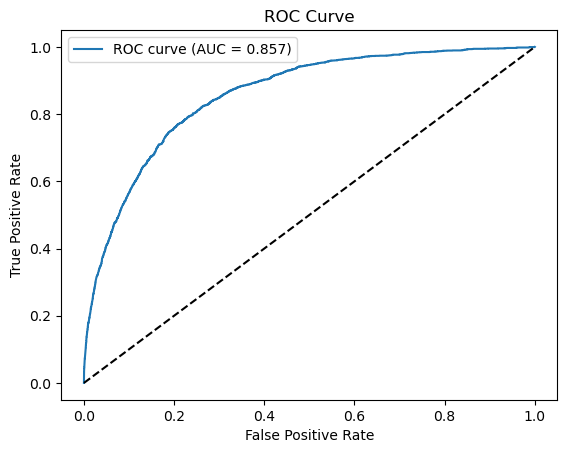

In [811]:
# ROC CURVE
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

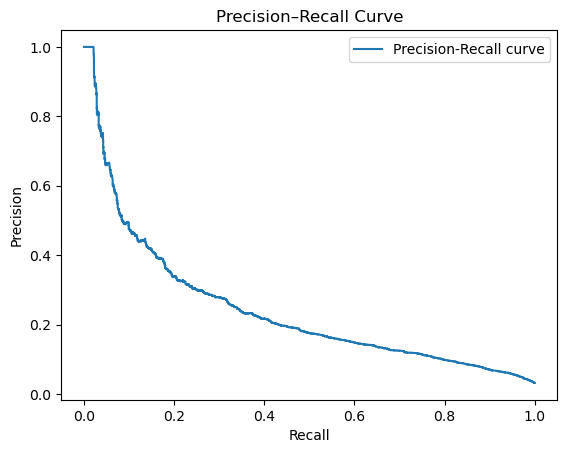

In [812]:
# PRS-REC CURVE
prec, rec, _ = precision_recall_curve(y, y_prob)
plt.plot(rec, prec, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

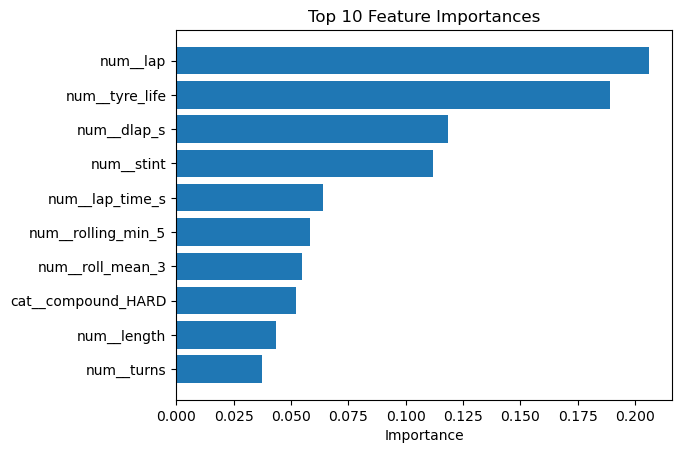

In [813]:
# FEATURE IMPORTANCES
# grab feature names after one-hot
feature_names = pipe.named_steps["pre"].get_feature_names_out()
importances = pipe.named_steps["clf"].feature_importances_
idx = np.argsort(importances)[::-1]

plt.barh(range(10), importances[idx][:10])
plt.yticks(range(10), feature_names[idx][:10])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()

## Moving onto Next Model:

#### Currently:
- Model: GradientBoostingClassifier, GroupKFold by race  
- Metrics: Acc ≈ 0.96, F1 ≈ 0.03 (predicts “no pit”)  

#### Weaknesses:
- **Extreme class imbalance**  
  - Pit windows are rare vs non-pit laps  
  - Model learns to always predict "no pit" => looks accurate, but misses the true events–– the ones that matter
- **Fixed 0.5 threshold**  
  - Probabilities rarely exceed 0.5 for minority class  
  - Positive cases nearly always classified as 0  
- **No class weighting**  
  - GradientBoostingClassifier doesn’t adjust for imbalance  
  - Minority errors not penalized enough => maybe here's some opportunity
- **Missing context features**  
  - No gaps to cars ahead/behind (undercut/overcut signals)  
  - No pit-lane loss time per circuit  
  - No safety car/VSC flags to capture sudden pit opportunities  

#### Path Forward:
1. Switch to weighted model (HistGradientBoosting, XGBoost, CatBoost)  
2. Calibrate probabilities and tune threshold (optimize PR-AUC, event recall)  
3. Add pit-economics features (pit loss, gaps, degradation slope, SC/VSC flags)  
4. Simulate race replays → measure time/position gains vs actual strategies  